# Отток клиентов из микрофинансовой организации

## Initial information

Необходимо создать модель, которая будет лучше всего предсказывать отток клиентов из МФО.\
На каждый займ (loan_id) из test.csv требуется спрогнозировать отток (1) или не отток (0).\
Исходные материалы:\
`train.csv` - датасет для обучения модели;\
`test.csv` - датасет для валидации модели;\
`sample_submission.csv` - пример файла результатов.\
Метрика качества - F1.\
Хакатон на платформе [Kaggle](https://www.kaggle.com/competitions/adengi-internship/overview).

Признаки
* <font color='green'>**monthly_income**</font> - среднемесячный заработок клиента (зарплата)
* <font color='green'>**payment_frequency**</font> - частота получения зарплаты (month - 1 раз в месяц, 2 weeks - раз в две недели, и тд) (вероятно подразумевается количество раз в месяц)
* <font color='green'>**status**</font> - статус клиента (самозанятый, рабочий, и тд)
* <font color='green'>**work_experience**</font> - кол-во лет стажа клиента
* <font color='green'>**client_type**</font> - тип клиента (новый, повторный)
* <font color='green'>**settlement**</font> - город клиента
* <font color='green'>**requested_sum**</font> - запрашиваемая сумма клиента для займа, если interface - alfa
* <font color='green'>**region**</font> - регион клиента (область, округ, и тд)
* <font color='green'>**loan_id**</font> - уникальный идентификатор займа
* <font color='green'>**client_id**</font> - уникальный идентификатор клиента
* <font color='green'>**main_agreement_amount**</font> - основная одобренная сумма клиенту по займу (может быть больше, чем approved_amount)
* <font color='green'>**main_agreement_term**</font> - основной одобренный срок по займу
* <font color='green'>**requested_period_days**</font> - запрашиваемый срок по займу
* <font color='green'>**requested_amount**</font> - запрашиваемая сумма клиента по займу
* <font color='green'>**req_app_amount**</font> - разница между запрашиваемой суммой займа и одобренной
* <font color='green'>**approved_amount**</font> - одобренная сумма по займу
* <font color='green'>**source**</font> - канал привлечения клиента
* <font color='green'>**first_source**</font> - первый канал привлечения клиента
* <font color='green'>**period_days**</font> - период страховки по займу
* <font color='green'>**interface**</font> - интерфейс, откуда пришла заявка - (site, mobile)
* <font color='green'>**created_at**</font> - дата открытия займа
* <font color='green'>**type**</font> - тип займа (тип продукта)
* <font color='green'>**closed_at**</font> - дата закрытия займа
* <font color='green'>**days_finish_loan**</font> - время в днях, затраченное на закрытие займа (closed_at - created_at)
* <font color='green'>**gender**</font> - пол клиента
* <font color='green'>**ag**</font> - возраст клиента
* <font color='green'>**repayment_type**</font> - Тип комиссии по займу (с 2.5% - with_comission, 5% - with_big_comission, 0% - no_comission)
* <font color='green'>**loan_order**</font> - порядковый номер займа
* <font color='green'>**have_extension**</font> - имеется ли пролонгация по данному займу
* <font color='green'>**cnt_ext**</font> - кол-во пролонгаций по займу
* <font color='green'>**start_dt**</font> - дата начала (список) пролонгаций по займу
* <font color='green'>**term**</font> - срок пролонгации (список)
* <font color='green'>**price**</font> - цена пролонгации (список)
* <font color='green'>**elecs_sum**</font> - штрафы, пени
* <font color='green'>**recurents_sum**</font> - штрафы, пени (там вроде как различия в этапах их начисления)
* <font color='green'>**tamount**</font> - общий кэшфлоу клиента (общая сумма которая была на аккаунте клиента)
* <font color='green'>**issues**</font> - сумма просрочек, штрафов и пени
* <font color='green'>**principal**</font> - сумма основного долга
* <font color='green'>**interest**</font> - прибыль с клиента
* <font color='green'>**overdue_interest**</font> - прибыль с клиента, если есть просрочка
* <font color='green'>**overdue_fee**</font> - штрафы в просрочек
* <font color='green'>**contact_cases**</font> - кол-во обращений клиента с коллекшн
* <font color='green'>**nbki_score**</font> - скор клиента от рисков

* <font color='green'>**churn**</font> - колонка таргета

## Libraries & functions

In [1]:
#!pip install category_encoders

In [2]:
import pandas as pd
import numpy as np
from pandas.plotting import table
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
import re
import phik
from matplotlib.patches import Rectangle, Patch
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score
import cudf
from cuml.linear_model import LogisticRegression
from category_encoders import TargetEncoder
from math import ceil
import torch
import torch.nn as nn
import sys
import warnings

In [3]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [4]:
random_state = 12345
np.random.seed(random_state)
torch.manual_seed(random_state)

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
def gaps(df):
    '''выводит сумму и долю пропусков; на входе dataframe'''
    return pd.DataFrame(df.isna().sum(),  columns = ['sum']).join(
           pd.DataFrame(df.isna().mean(), columns = ['share']))

In [7]:
def description(train, test):
    '''По двум Series-количественным признакам рисует диаграммы размаха, гистограммы, число пропусков и табл. со статистиками'''
    f, ax = plt.subplots(3,2, gridspec_kw={"height_ratios": (.15, .15, .85), 
                                           "width_ratios":  (.85, .15)}, figsize=(9,4))
    
    # Связываем оси левого столбца (в инициализации сверху нельзя, т.к. есть pie)
    ax[0, 0].sharex(ax[1, 0])
    ax[1, 0].sharex(ax[2, 0])
    
    blue   = '#5d72f5'; orange = '#f27a11'; grey = '#949392'
        
    sns.boxplot (x=train, ax=ax[0,0], color=blue)
    sns.boxplot (x=test,  ax=ax[1,0], color=orange)
    sns.histplot(x=train, bins=500, ax=ax[2,0], element="step", alpha=0.3, color=blue)
    sns.histplot(x=test,  bins=500, ax=ax[2,0], element="step", alpha=0.3, color=orange)
    
    # pie
    gap_share_train = train.isna().mean()
    gap_share_test  = test.isna().mean()
    gap_sum_train   = train.isna().sum()
    gap_sum_test    = test.isna().sum()
    s_train = pd.Series([1-gap_share_train,gap_share_train], ['fill','gap'])
    s_test  = pd.Series([1-gap_share_test, gap_share_test],  ['fill','gap'])
    s_train.plot(kind='pie', colors = [blue, grey],   ax=ax[0,1], labels=None, label='')
    s_test. plot(kind='pie', colors = [orange, grey], ax=ax[1,1], labels=None, label='')
    ax[0,1].text(1.2,-0.6, f'gaps: {gap_share_train:.0%}, {gap_sum_train} pcs.', fontsize=9)
    ax[1,1].text(1.2,-0.6, f'gaps: {gap_share_test:.0%},  {gap_sum_test} pcs.',  fontsize=9)
        
    # table with characteristics
    _ = pd.concat([train.describe(), 
                   test.describe()],axis=1).round(2)
    _.columns = ['train','test']
    table(data=_, ax=ax[2,1], loc='right', colWidths=[.9, .9], fontsize=9)
    
    # decoration
    ax[0,0].set(yticks=[], xlabel=None); ax[1,0].set(yticks=[], xlabel=None)
    sns.despine(ax=ax[2,0])
    sns.despine(ax=ax[0,0], left=True); sns.despine(ax=ax[1,0], left=True)
    plt.axis('off')
    ax[2,0].legend(['train', 'test'])
    f.suptitle(f'{train.name} distribution')

In [8]:
def description_cat(train, test, values=False):
    '''По двум Series-категориальным признакам рисует столбчатые диаграммы и число пропусков'''
    
    blue   = '#5d72f5'; orange = '#f27a11'; grey = '#949392'
    
    fig = plt.figure(figsize=(11,3))
    gs = GridSpec(2, 2, figure=fig, width_ratios=(.9, .1))
    
    # create sub plots as grid
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])
    
    sns.countplot(data=
                  pd.concat([
                      pd.concat([train, pd.Series('train', train.index)], axis=1), 
                      pd.concat([test,  pd.Series('test',  test.index)],  axis=1)]), 
                  x=train.name,
                  hue=0,
                  order=train.value_counts().index,
                  palette=[blue, orange],
                  ax=ax1)
    if values:
        for p in ax1.patches:
            ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    
    # pie
    gap_share_train = train.isna().mean()
    gap_share_test  = test.isna().mean()
    gap_sum_train   = train.isna().sum()
    gap_sum_test    = test.isna().sum()
    s_train = pd.Series([1-gap_share_train,gap_share_train], ['fill','gap'])
    s_test  = pd.Series([1-gap_share_test, gap_share_test],  ['fill','gap'])
    s_train.plot(kind='pie', colors = [blue, grey],   ax=ax2, labels=None, label='')
    s_test. plot(kind='pie', colors = [orange, grey], ax=ax3, labels=None, label='')
    ax2.text(1.2,-0.6, f'gaps: {gap_share_train:.0%}, {gap_sum_train} pcs.', fontsize=9)
    ax3.text(1.2,-0.6, f'gaps: {gap_share_test:.0%},  {gap_sum_test} pcs.',  fontsize=9)
    
    # decoration
    sns.despine()
    fig.suptitle(f'{train.name} distribution')

In [9]:
def distribution(data, feature, goal='churn', bins=400):
    '''распределение признака с разбивкой по целевому'''
    plt.figure(figsize=(10,3))
    sns.histplot(data=data, x=feature, hue=goal, bins=bins)
    plt.title(f'{feature} distribution with splitting by {goal}')
    sns.despine()

In [10]:
def matrix_corr(df, title='', corner = True):
    '''рисует Phi_K матрицу; на входе df; 1-ым столбцом в df должен быть target (если он есть)'''
    if corner:
        matrix = np.tri(len(df)).T
    else:
        matrix = None
        
    plt.figure(figsize=(10.5,6))
    ax = sns.heatmap(df*100, mask=matrix, annot=True, cmap='Blues',
                     fmt='.0f', annot_kws={"size":8})
    
    # decoration
    plt.title('Phi_K correlation (*100)'+title)

    if corner:
        ax.annotate('target', xy=(1.2, 0.8), xytext=(5, 2), color='red',
                    arrowprops=dict(arrowstyle="->", 
                                    connectionstyle="angle3, angleA=-30, angleB=20", color = 'red'))
        ax.add_patch(Rectangle(( 0, int(corner)), 1, df.shape[0]-int(corner), fill=False,
                    edgecolor='crimson', lw=1.5, clip_on=False))

In [11]:
class scaling_coding():
    '''стандартизация и кодирование (OHE и/или TargetEncoder); на входе df и списки соответствующих колонок; на выходе array'''
    def __init__(self, cols_scale=None, cols_ohe=None, cols_te=None, cols_untransformed=None):
        self.cols_scale         = cols_scale
        self.cols_ohe           = cols_ohe
        self.cols_te            = cols_te
        self.cols_untransformed = cols_untransformed
        
    def fit(self, X, y=None, max_categories=None):
        if self.cols_scale:
            self.scaler = StandardScaler()
            self.scaler.fit(X[self.cols_scale])
        if self.cols_ohe:
            self.encoder_ohe = OneHotEncoder(handle_unknown = 'ignore', max_categories = max_categories, sparse_output=False)
            self.encoder_ohe.fit(X[self.cols_ohe])
        if self.cols_te:
            self.encoder_t = TargetEncoder(cols=self.cols_te)
            self.encoder_t.fit(X[self.cols_te], y)
        
    def transform(self, X, d_type='float32'):
        array_scale, array_ohe, array_te, array_untransformed = None, None, None, None
        if self.cols_scale:
            array_scale = self.scaler.transform(X[self.cols_scale]).astype(d_type)
        if self.cols_ohe:
            array_ohe   = self.encoder_ohe.transform(X[self.cols_ohe]).astype(d_type)
        if self.cols_te:
            array_te    = self.encoder_t.transform(X[self.cols_te]).astype(d_type)
        if self.cols_untransformed:
            array_untransformed= X[self.cols_untransformed].values

        return np.concatenate([array 
                               for array in (array_scale, array_ohe, array_te, array_untransformed) 
                               if  array is not None], axis=1)

In [12]:
def memory():
    '''формирует df из глобыльных переменных, их id, и занимаемую ими память, МБ'''
    m = pd.DataFrame(
        [(var, 
          id(globals()[var]), 
          sys.getsizeof(globals()[var])/1024**2) for var in list(globals().keys())], 
        columns=['variable','id', 'size, MB']).\
        set_index('variable').\
        sort_values('size, MB', ascending=False)
    m['size, MB'] = m['size, MB'].astype('int')
    return m[m['size, MB']>1]

## Exploratory Data Analysis

In [13]:
try:
    train             = pd.read_csv('train.csv')
    test              = pd.read_csv('test.csv')
    sample_submission = pd.read_csv('sample_submission.csv')
except:
    train             = pd.read_csv('/kaggle/input/adengi/train.csv')
    test              = pd.read_csv('/kaggle/input/adengi/test.csv')
    sample_submission = pd.read_csv('/kaggle/input/adengi/sample_submission.csv')

### General by tables

In [14]:
train.head(3)

monthly_income  work_experience  requested_sum  main_agreement_amount  \
0       -0.000735         0.952894            NaN              -0.388291   
1       -0.000742         0.952894            NaN              -0.388291   
2       -0.000742         0.952894            NaN              -0.388291   

   main_agreement_term  requested_period_days  requested_amount  \
0            -0.340659              -0.389028         -1.053530   
1            -1.145865              -1.294731         -0.436189   
2            -0.685747              -1.113590         -0.259806   

   req_app_amount  approved_amount  period_days  days_finish_loan        ag  \
0       -0.629296         -0.61762    -0.340659         -0.539615 -0.619312   
1       -0.020140         -0.61762    -1.145865         -0.539615  1.354330   
2        0.153905         -0.61762    -0.685747         -0.502706  1.354330   

   cnt_ext  term  price  elecs_sum  recurents_sum   tamount    issues  \
0      NaN   NaN    NaN  -0.063933      -0.143015 -0.434972  0.347703   
1      NaN   NaN    NaN  -0.063933      -0.143015 -0.434972  0.347703   
2      NaN   NaN    NaN  -0.063933      -0.143015 -0.429509  0.347703   

   principal  interest  overdue_interest  overdue_fee  nbki_score  \
0  -0.347703 -0.502878         -0.218265    -0.185707    1.837622   
1  -0.347703 -0.502878         -0.218265    -0.185707    2.262600   
2  -0.347703 -0.484111         -0.218265    -0.185707    2.262600   

   payment_frequency  status  loan_id  client_id  source  first_source  \
0                  2       1   464867     111035      11             0   
1                  2       1  4569010     604426      11             0   
2                  2       1   985489     334703      11             4   

   interface  type  repayment_type  client_type settlement client_type.1  \
0          0     2               3            1   г Москва      repeated   
1          2     1               0            1   г Москва      repeated   
2          2     2               3            1    г Пермь      repeated   

          region  gender  loan_order  have_extension  contact_cases  \
0       г Москва    male           2               0            NaN   
1       г Москва  female          14               0            NaN   
2  край Пермский    male          10               0            NaN   

            created_at            closed_at start_dt  churn  
0  2022-12-23 17:50:25  2022-12-31 16:09:23      NaN      0  
1  2024-06-29 22:26:08  2024-07-27 16:21:49      NaN      0  
2  2023-04-10 21:06:38  2023-05-10 07:51:18      NaN      0

In [15]:
test.head(3)

monthly_income  work_experience  requested_sum  main_agreement_amount  \
0       -0.000742         0.952894            NaN              -0.089509   
1       -0.000742         0.952894            NaN               4.242822   
2       -0.000749        -1.653445            NaN              -0.687072   

   main_agreement_term  requested_period_days  requested_amount  \
0             0.176974              -1.385301          0.181151   
1             8.114011                    NaN          1.239449   
2             0.176974              -1.385301         -1.053530   

   req_app_amount  approved_amount  period_days  days_finish_loan        ag  \
0        0.414972        -0.350380     0.176974         -0.539615  1.354330   
1       -1.760586         4.593562     8.114011          0.586136  1.562082   
2       -0.455251        -0.884860     0.176974         -0.539615 -0.619312   

   cnt_ext  term  price  elecs_sum  recurents_sum   tamount    issues  \
0      NaN   NaN    NaN  -0.063933      -0.143015 -0.245566  0.095187   
1      NaN   NaN    NaN  -0.063933      -0.143015  3.180674 -3.566293   
2      NaN   NaN    NaN  -0.063933      -0.143015 -0.613451  0.600219   

   principal  interest  overdue_interest  overdue_fee  nbki_score  \
0  -0.095187 -0.477855         -0.218265    -0.185707    2.262600   
1   3.566293  2.207618         -0.189042    -0.118661    2.262600   
2  -0.600219 -0.490367         -0.218265    -0.185707    0.783852   

   payment_frequency  status  loan_id  client_id  source  first_source  \
0                  2       1  4057275     594851      11             0   
1                  2       5   548313     143027      11             0   
2                  2       1  1978430     766940       0             0   

   interface  type  repayment_type  client_type      settlement client_type.1  \
0          0     2               1            1        г Москва      repeated   
1          2     2               3            1       г Коркино      repeated   
2          2     2               2            0  г Екатеринбург           new   

             region  gender  loan_order  have_extension  contact_cases  \
0          г Москва    male          15               0            NaN   
1   обл Челябинская  female           5               0            NaN   
2  обл Свердловская    male           1               0            NaN   

            created_at start_dt  
0  2024-04-29 18:20:22      NaN  
1  2023-01-17 04:59:57      NaN  
2  2023-08-29 14:04:47      NaN

In [16]:
# сохраним список исходных колонок для последующего анализа и сравнения с вновь созданными
cols_initial = train.columns.tolist()

In [17]:
sample_submission.head(3)

loan_id  churn
0  4057275      0
1   548313      1
2  1978430      1

In [18]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348743 entries, 0 to 1348742
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   loan_id  1348743 non-null  int64
 1   churn    1348743 non-null  int64
dtypes: int64(2)
memory usage: 20.6 MB


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4036207 entries, 0 to 4036206
Data columns (total 45 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   monthly_income         float64
 1   work_experience        float64
 2   requested_sum          float64
 3   main_agreement_amount  float64
 4   main_agreement_term    float64
 5   requested_period_days  float64
 6   requested_amount       float64
 7   req_app_amount         float64
 8   approved_amount        float64
 9   period_days            float64
 10  days_finish_loan       float64
 11  ag                     float64
 12  cnt_ext                float64
 13  term                   float64
 14  price                  float64
 15  elecs_sum              float64
 16  recurents_sum          float64
 17  tamount                float64
 18  issues                 float64
 19  principal              float64
 20  interest               float64
 21  overdue_interest       float64
 22  overdue_fee       

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348743 entries, 0 to 1348742
Data columns (total 43 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   monthly_income         1348680 non-null  float64
 1   work_experience        463225 non-null   float64
 2   requested_sum          163790 non-null   float64
 3   main_agreement_amount  1348743 non-null  float64
 4   main_agreement_term    1348743 non-null  float64
 5   requested_period_days  1200882 non-null  float64
 6   requested_amount       1209772 non-null  float64
 7   req_app_amount         1209772 non-null  float64
 8   approved_amount        1348743 non-null  float64
 9   period_days            1348743 non-null  float64
 10  days_finish_loan       1348743 non-null  float64
 11  ag                     1348743 non-null  float64
 12  cnt_ext                151701 non-null   float64
 13  term                   151701 non-null   float64
 14  price             

In [21]:
gaps(train).join(gaps(test), how='outer', lsuffix='_train', rsuffix='_test').\
style.format({'sum_train':  '{:.0f}', 'sum_test':  '{:.0f}', 
              'share_train':'{:.2f}', 'share_test':'{:.2f}'}).background_gradient()

In [22]:
# добавление индикаторов пропущенных значений
missing_cols = train.columns[train.isna().any()].tolist()

for df in (train,test):
    for col in missing_cols:
        df[f'{col}_missing'] = df[col].isna().astype(int)

In [23]:
train.duplicated().sum()

0

In [24]:
test.duplicated().sum()

0

In [25]:
train.drop('loan_id', axis=1).duplicated().sum()

0

In [26]:
test.drop('loan_id', axis=1).duplicated().sum()

0

### Detailed by features

#### churn

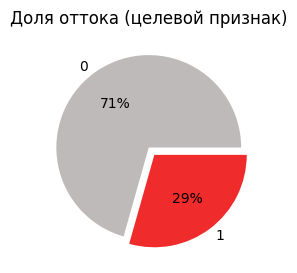

In [27]:
train.churn.value_counts().plot(kind   ='pie', autopct='%1.0f%%', explode = (0,0.1), 
                                colors = ['#bfbaba', '#f02b2b'], label = '',
                                title  = 'Доля оттока (целевой признак)',
                                figsize=(3,3)); plt.show()

Дисбаланс ~3/7.

#### ag

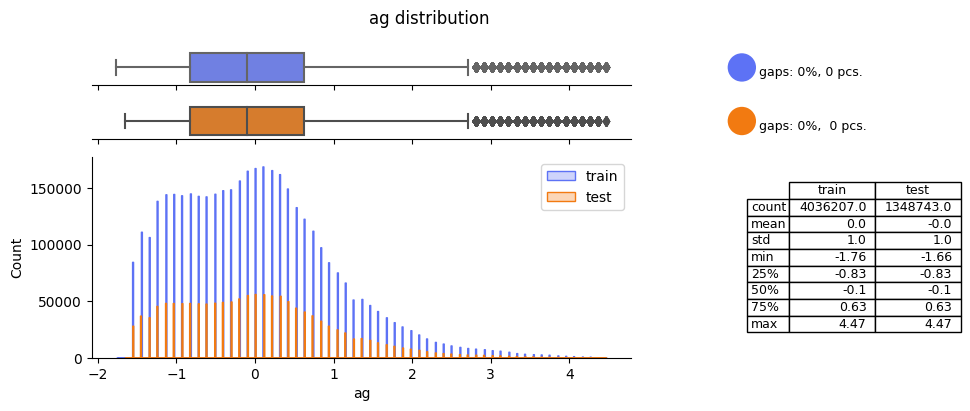

In [28]:
description(train.ag, test.ag)

#### monthly_income

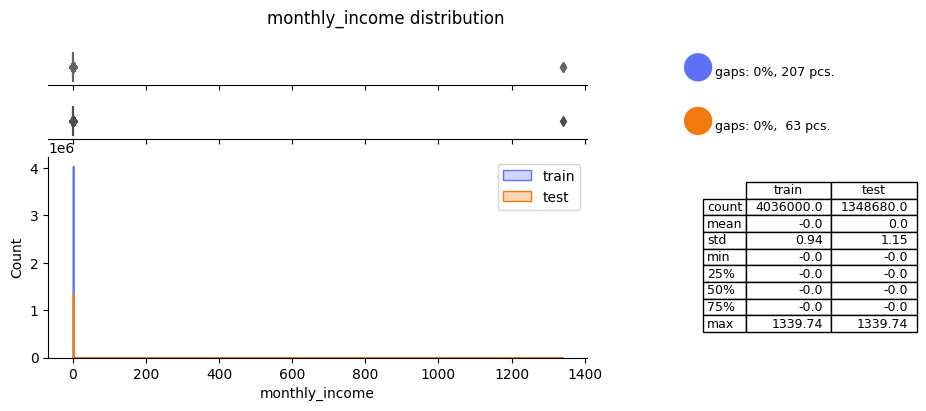

In [29]:
description(train.monthly_income, test.monthly_income)

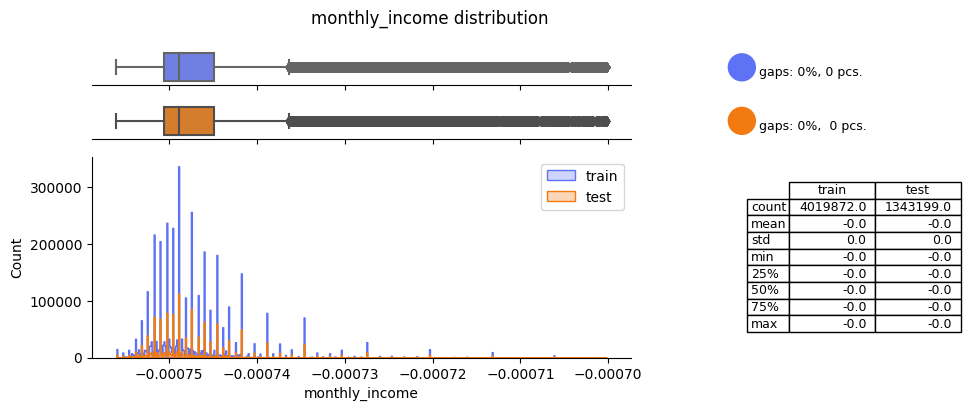

In [30]:
description(train.monthly_income[train.monthly_income<-0.0007], 
            test.monthly_income [test.monthly_income <-0.0007])

In [31]:
train[train.monthly_income>1].shape[0]                               # кол-во выбросов > 1 в train

2

In [32]:
round(train[train.monthly_income>-0.0007].shape[0]/train.shape[0],3) # доля выбросов > -0.0007 в train

0.004

In [33]:
test [test.monthly_income>1].shape[0]                                # кол-во выбросов > 1 в test

1

In [34]:
round(test[test.monthly_income>-0.0007].shape[0]/test.shape[0],3)    # доля выбросов > -0.0007 в test

0.004

Выбрасы >1 (явная кратная ошибка) - приравниваем к среднему, рассчитанному на train без выбросов.\
Всё что выше -0.0007 принимаем за выброс и приравниваем к -0007.

Пропуски заполняем среднем.

In [35]:
train_monthly_income_mean = train.loc[train.monthly_income<=-0.0007, 'monthly_income'].mean()

train.loc[train.monthly_income>1, 'monthly_income'] = train_monthly_income_mean
test.loc [test.monthly_income>1,  'monthly_income'] = train_monthly_income_mean

In [36]:
train.loc[train.monthly_income>-0.0007, 'monthly_income'] = -0.0007
test.loc [test.monthly_income>-0.0007,  'monthly_income'] = -0.0007

In [37]:
train.monthly_income.fillna(train_monthly_income_mean, inplace=True)
test. monthly_income.fillna(train_monthly_income_mean, inplace=True)

#### requested_sum

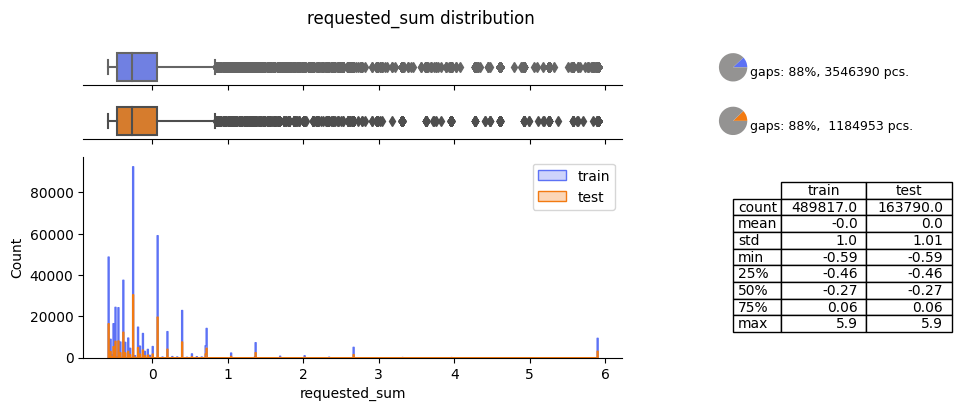

In [38]:
description(train.requested_sum, test.requested_sum)

In [39]:
round(train[train.requested_sum.isna()].churn.mean(), 2)  # доля исходов в пропусках

0.29

In [40]:
round(train[~train.requested_sum.isna()].churn.mean(), 2) # доля исходов в НЕпропусках

0.29

Признак, практически не влияет на целевой. Заполнять пропуски и применять его в  ML не будем.\
Существующие значения возьмём для заполнения пропусков в `requested_amount`.

#### requested_amount

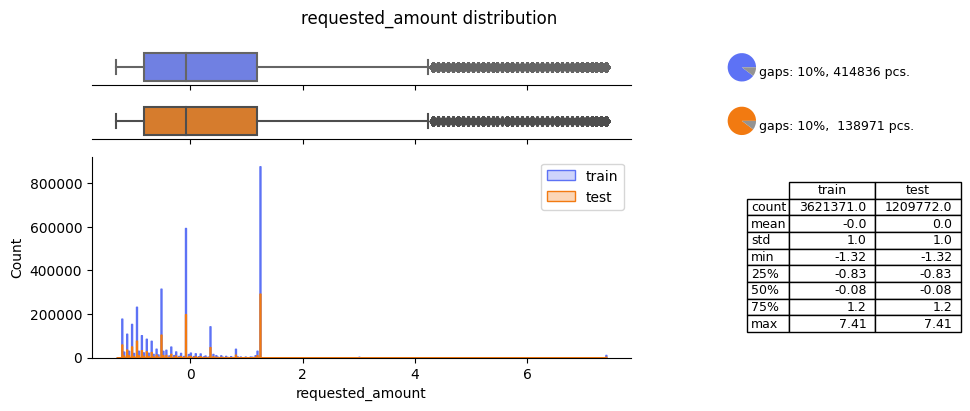

In [41]:
description(train.requested_amount, test.requested_amount)

Проверим, одни ли это и те же объекты с пропусками в `requested_amount` и `req_app_amount`:

In [42]:
train[train.requested_amount.isna() & train.req_app_amount.isna()].shape[0]

414836

In [43]:
test[test.requested_amount.isna() & test.req_app_amount.isna()].shape[0]

138971

Да, пропуски у одних объектов.

In [44]:
# доля пропусков одновременно в requested_amount и requested_sum
round(train[train.requested_amount.isna() & 
            train.requested_sum.isna()].shape[0]/train.shape[0], 2)

0.03

In [45]:
# доля НЕпропусков одновременно в requested_amount и requested_sum
round(train[~train.requested_amount.isna() & 
            ~train.requested_sum.isna()].shape[0]/train.shape[0], 2)

0.04

Непонятно, почему есть объекты где одновременно могут либо отсутствовать значения в `requested_amount` и `requested_sum`, либо одновременно присутствовать. Их немного.

In [46]:
# доля, когда есть значение только в 1 признаке из 2 (requested_amount, requested_sum)
round(train[train.requested_amount.isna() ^ 
            train.requested_sum.isna()].shape[0]/train.shape[0], 2)

0.93

In [47]:
# доля, когда есть значение в requested_sum, а в requested_amount нет
round(train[ train.requested_amount.isna() & 
            ~train.requested_sum.isna()].shape[0]/train.shape[0], 2)

0.08

Пропуски в `requested_amount` заполним значениями из `requested_sum`.\
Хоть значения стандартизованы, но распределения достаточно похожи, близки (min, max, mean).

In [48]:
train.loc[train.requested_amount.isna(), 'requested_amount'] =\
train.loc[train.requested_amount.isna(), 'requested_sum']

test.loc[test.requested_amount.isna(), 'requested_amount'] =\
test.loc[test.requested_amount.isna(), 'requested_sum']

Оставшиеся 3% пропусков заполним средним.

In [49]:
requested_amount_mean = train.requested_amount.mean()

train.requested_amount.fillna(requested_amount_mean, inplace=True)
test. requested_amount.fillna(requested_amount_mean, inplace=True)

#### approved_amount

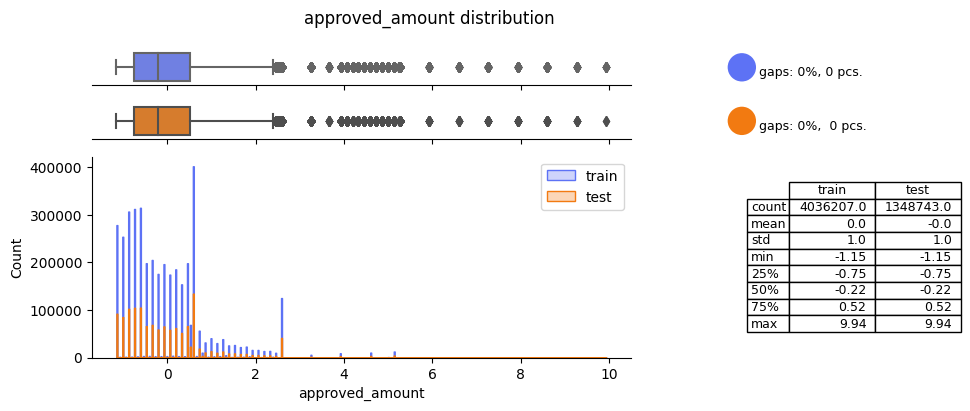

In [50]:
description(train.approved_amount, test.approved_amount)

#### main_agreement_amount

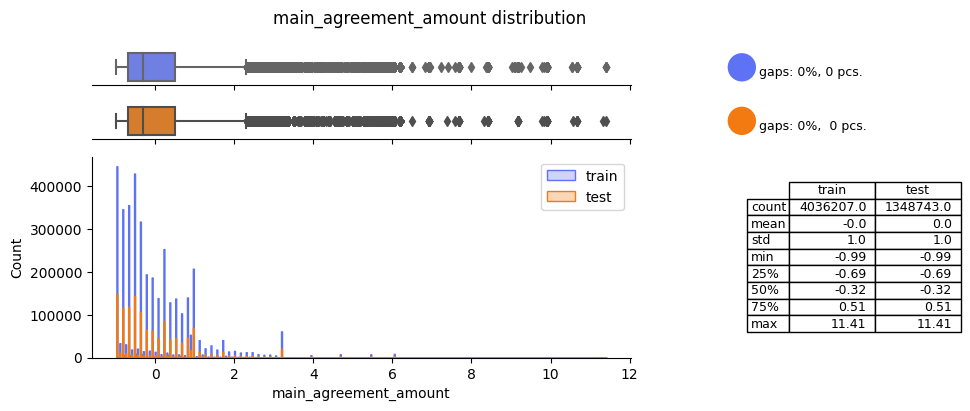

In [51]:
description(train.main_agreement_amount, test.main_agreement_amount)

#### req_app_amount

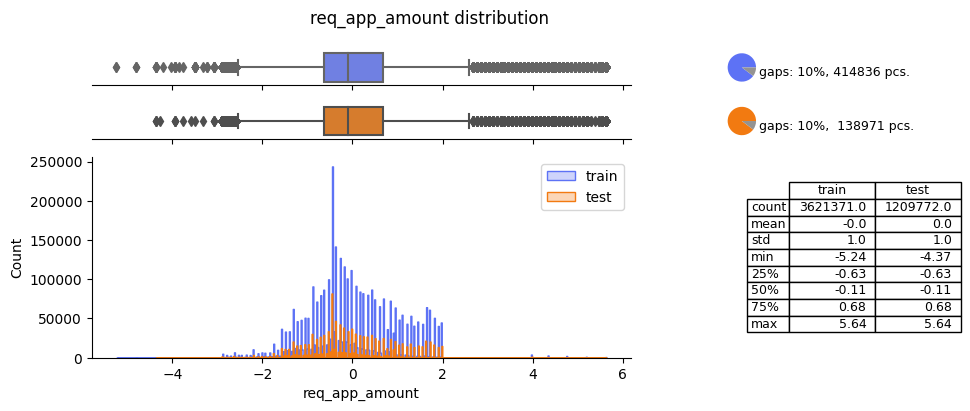

In [52]:
description(train.req_app_amount, test.req_app_amount)

Пропуски заполним разницей `requested`-`approved`.\
Только нужно убедиться, что это не разница `approved`-`requested`:

In [53]:
train[['requested_amount', 'approved_amount','req_app_amount']].join\
(pd.DataFrame(train.requested_amount-train.approved_amount, columns=['req-app'])).join\
(pd.DataFrame(train.approved_amount-train.requested_amount, columns=['app-req'])).head()

requested_amount  approved_amount  req_app_amount   req-app   app-req
0         -1.053530         -0.61762       -0.629296 -0.435910  0.435910
1         -0.436189         -0.61762       -0.020140  0.181431 -0.181431
2         -0.259806         -0.61762        0.153905  0.357814 -0.357814
3          1.239449         -0.61762        1.633284  1.857069 -1.857069
4          0.357534         -0.61762        0.763061  0.975154 -0.975154

`req-app` ближе к `req_app_amount`, чем `app-req`.

In [54]:
train.loc[train.req_app_amount.isna(), 'req_app_amount'] =\
train.requested_amount-train.approved_amount

test.loc[test.req_app_amount.isna(), 'req_app_amount'] =\
test.requested_amount-test.approved_amount

#### tamount

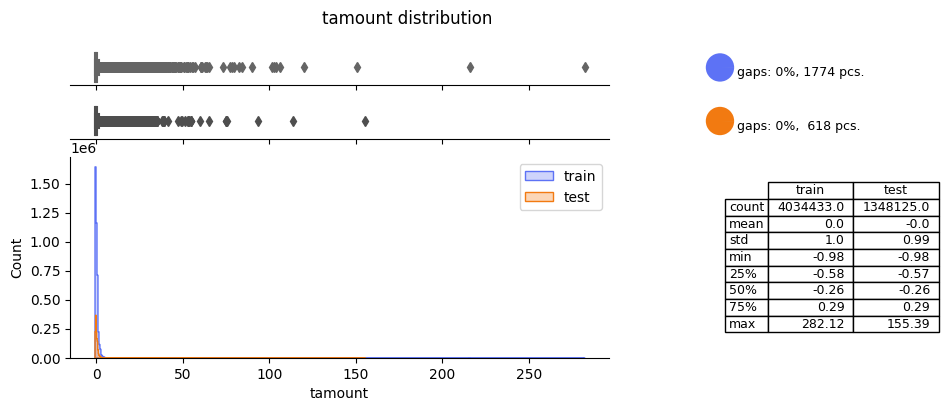

In [55]:
description(train.tamount, test.tamount)

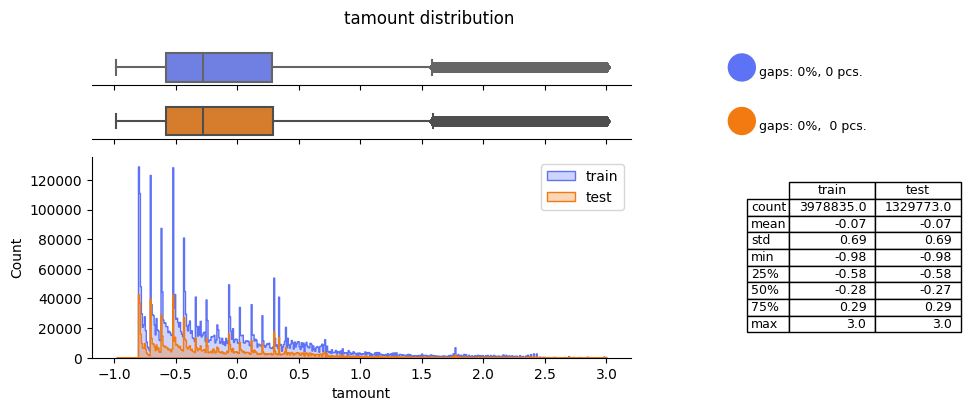

In [56]:
description(train.tamount[train.tamount<=3], test.tamount[test.tamount<=3])

In [57]:
round(train.tamount[train.tamount>3].shape[0]/train.shape[0], 2) # доля выбросов > 3

0.01

In [58]:
# выбросы уменьшаем до 3
train.loc[train.tamount>3, 'tamount'] = 3
test .loc[test. tamount>3, 'tamount'] = 3

In [59]:
round(train[train.tamount.isna()].churn.mean(),2) # доля исходов среди пропусков

0.29

In [60]:
round(train[~train.tamount.isna()].churn.mean(),2) # доля исходов среди НЕпропусков

0.29

In [61]:
# проверим, есть ли финансовая активность в других признаках
train[train.tamount.isna()][['tamount', 'requested_amount', 
                             'req_app_amount', 'approved_amount']].head()

tamount  requested_amount  req_app_amount  approved_amount
3765       NaN          1.239449        1.546261        -0.484000
8578       NaN          1.239449        0.850083         0.584960
10584      NaN         -0.003083        0.997759        -1.000842
32238      NaN         -0.083423        0.066883        -0.216760
34956      NaN         -0.788955       -0.368229        -0.617620

Активность есть. Причина пропуска неясна. Заполним средним.

In [62]:
tamount_mean = train.tamount.mean()

train.tamount.fillna(tamount_mean, inplace=True)
test. tamount.fillna(tamount_mean, inplace=True)

#### principal

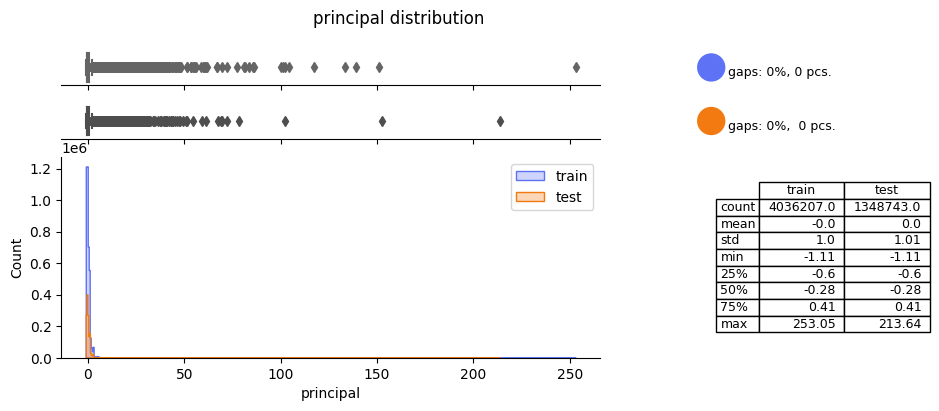

In [63]:
description(train.principal, test.principal)

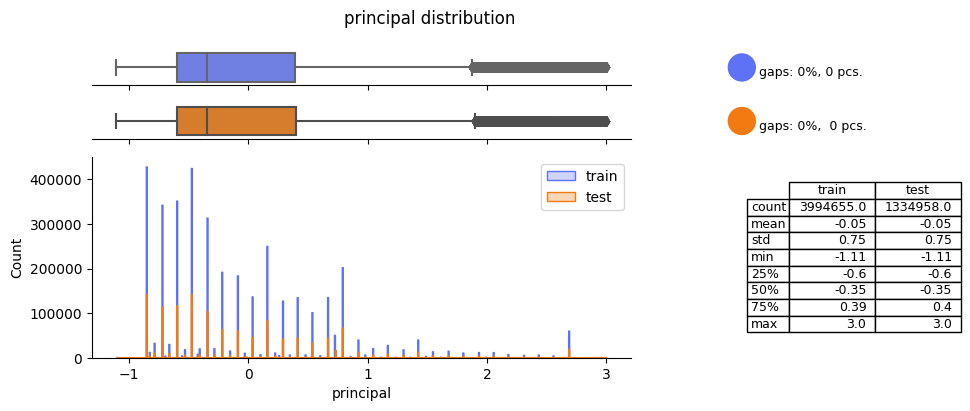

In [64]:
description(train.principal[train.principal<=3], test.principal[test.principal<=3])

In [65]:
round(train.principal[train.principal>3].shape[0]/train.shape[0], 2) # доля выбросов > 3

0.01

In [66]:
# выбросы уменьшаем до 3
train.loc[train.principal>3, 'principal'] = 3
test .loc[test. principal>3, 'principal'] = 3

#### price

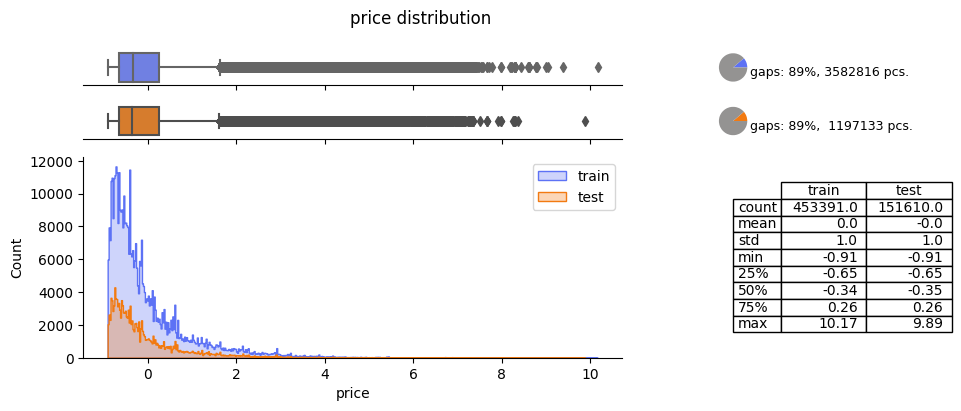

In [67]:
description(train.price, test.price)

Предположим, что пропуски соответствуют нулю руб.\
Заполним значением немного меньше минимального (-1).

In [68]:
train.price.fillna(-1, inplace=True)
test. price.fillna(-1, inplace=True)

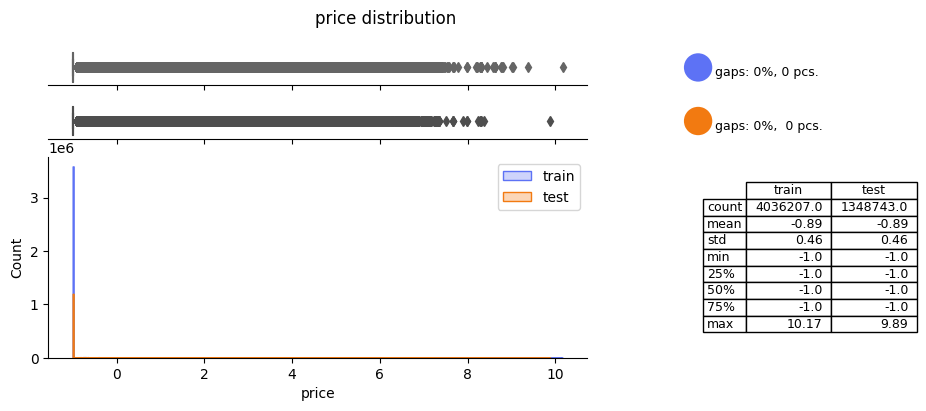

In [69]:
description(train.price, test.price)

#### elecs_sum

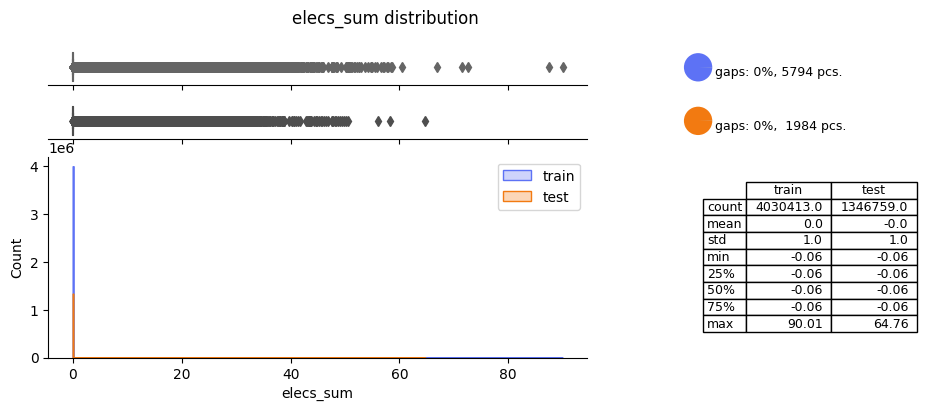

In [70]:
description(train.elecs_sum, test.elecs_sum)

До нормализации, скорее всего, при отсутствии штрафа стояли 0.\
Предположим, что пропуск - это отсутствие штрафа, т.е. 0 руб.\
Заполним пропуски минимальным значением.

In [71]:
elecs_sum_min = train.elecs_sum.min()

train.elecs_sum.fillna(elecs_sum_min, inplace=True)
test. elecs_sum.fillna(elecs_sum_min, inplace=True)

#### recurents_sum

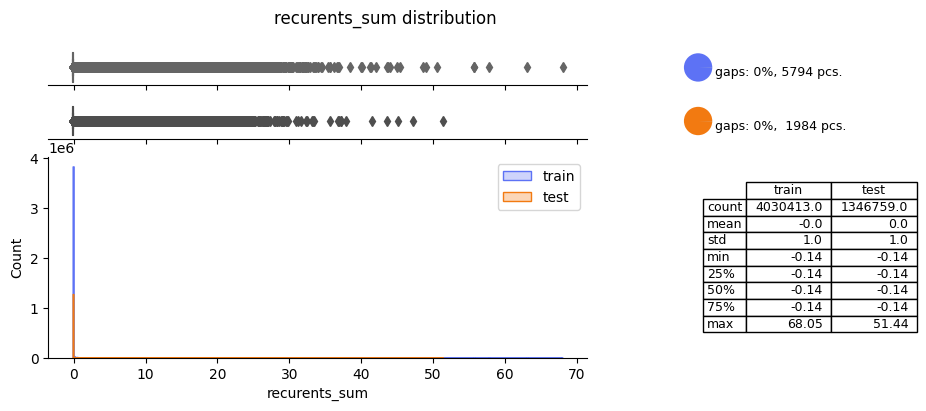

In [72]:
description(train.recurents_sum, test.recurents_sum)

In [73]:
recurents_sum_min = train.recurents_sum.min()

train.recurents_sum.fillna(recurents_sum_min, inplace=True)
test. recurents_sum.fillna(recurents_sum_min, inplace=True)

#### issues

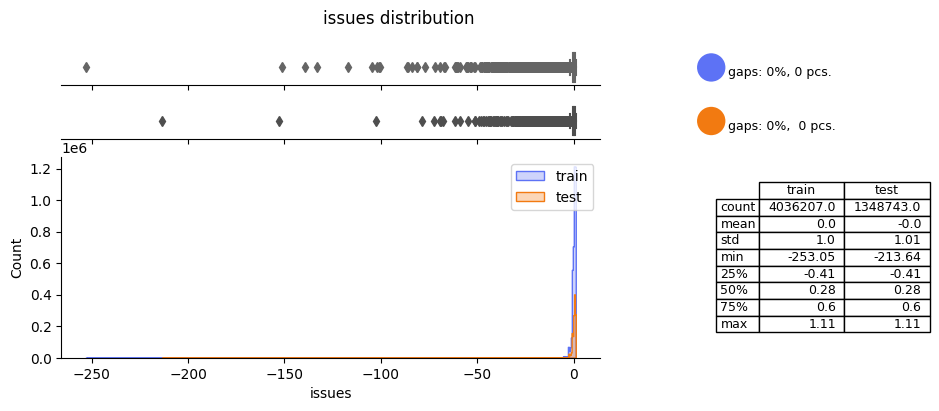

In [74]:
description(train.issues, test.issues)

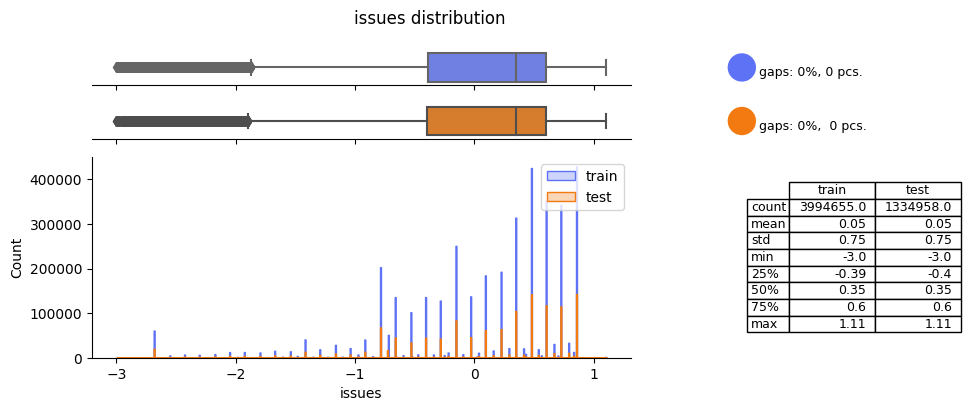

In [75]:
description(train.issues[train.issues>=-3], test.issues[test.issues>=-3])

In [76]:
round(train.issues[train.issues<-3].shape[0]/train.shape[0], 2) # доля выбросов < -3

0.01

In [77]:
# выбросы уменьшаем до -3
train.loc[train.issues<-3, 'issues'] = -3
test .loc[test. issues<-3, 'issues'] = -3

#### interest

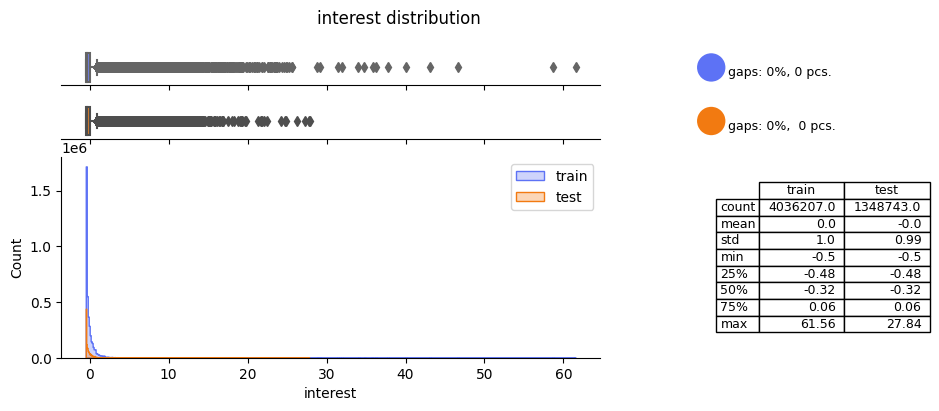

In [78]:
description(train.interest, test.interest)

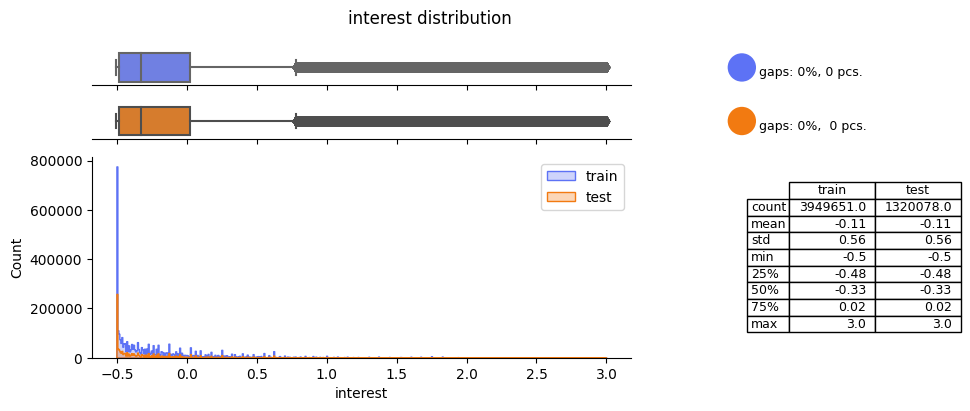

In [79]:
description(train.interest[train.interest<=3], test.interest[test.interest<=3])

In [80]:
round(train.interest[train.interest>3].shape[0]/train.shape[0], 2) # доля выбросов > 3

0.02

In [81]:
# выбросы уменьшаем до 3
train.loc[train.interest>3, 'interest'] = 3
test .loc[test. interest>3, 'interest'] = 3

#### overdue_interest

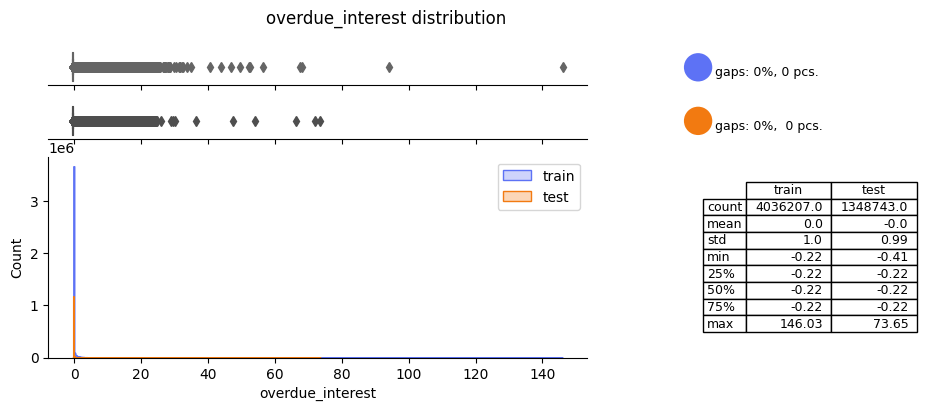

In [82]:
description(train.overdue_interest, test.overdue_interest)

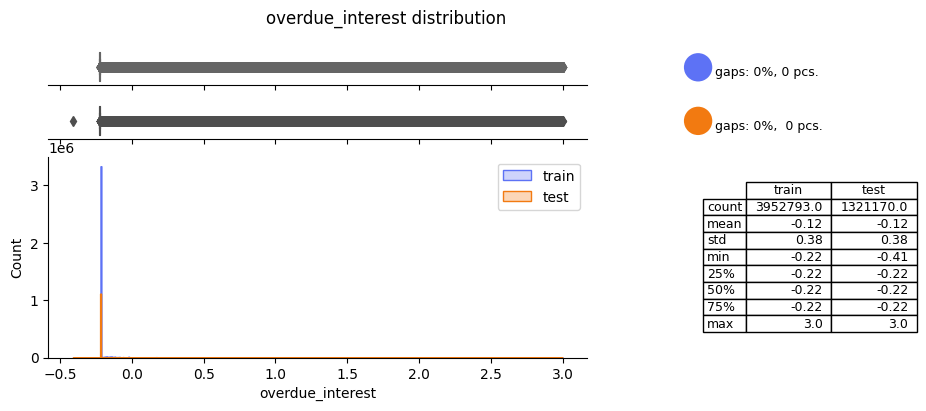

In [83]:
description(train.overdue_interest[train.overdue_interest<=3], 
            test.overdue_interest[test.overdue_interest<=3])

In [84]:
round(train.overdue_interest[train.overdue_interest>3].shape[0]/train.shape[0], 2) # доля выбросов > 3

0.02

In [85]:
# выбросы уменьшаем до 3
train.loc[train.overdue_interest>3, 'overdue_interest'] = 3
test .loc[test. overdue_interest>3, 'overdue_interest'] = 3

#### overdue_fee

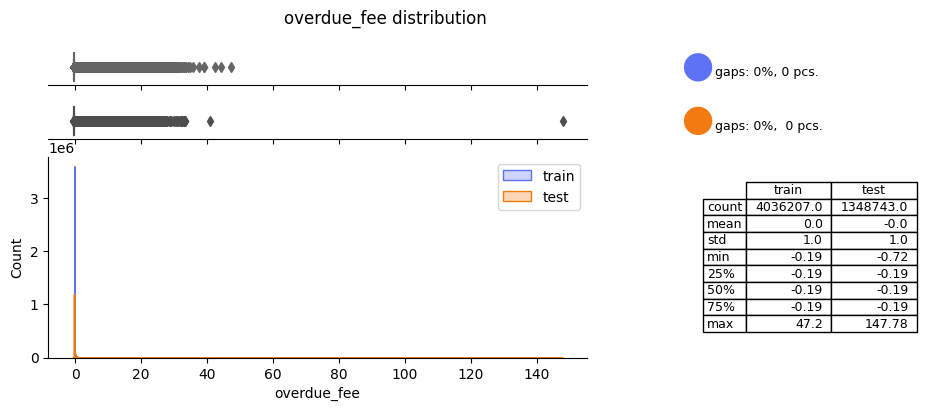

In [86]:
description(train.overdue_fee, test.overdue_fee)

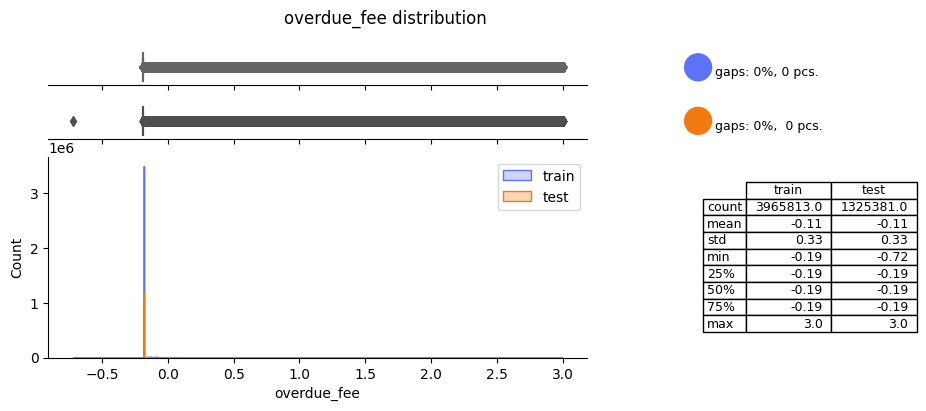

In [87]:
description(train.overdue_fee[train.overdue_fee<=3], 
            test.overdue_fee[test.overdue_fee<=3])

In [88]:
round(train.overdue_fee[train.overdue_fee>3].shape[0]/train.shape[0], 2) # доля выбросов > 3

0.02

In [89]:
# выбросы уменьшаем до 3
train.loc[train.overdue_fee>3, 'overdue_fee'] = 3
test .loc[test. overdue_fee>3, 'overdue_fee'] = 3

#### status

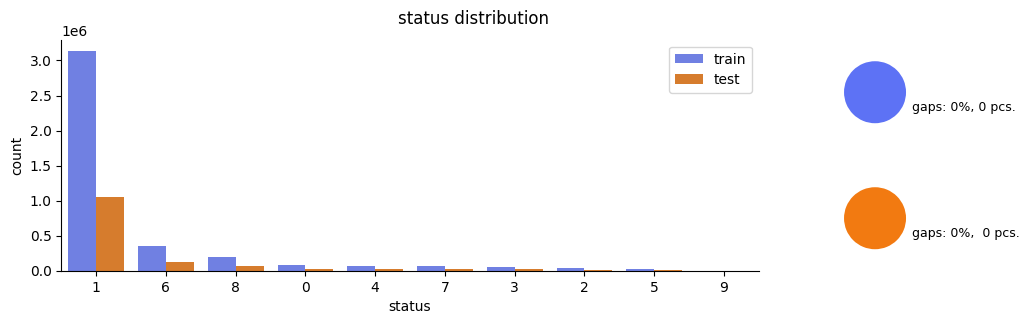

In [90]:
description_cat(train.status, test.status)

#### gender

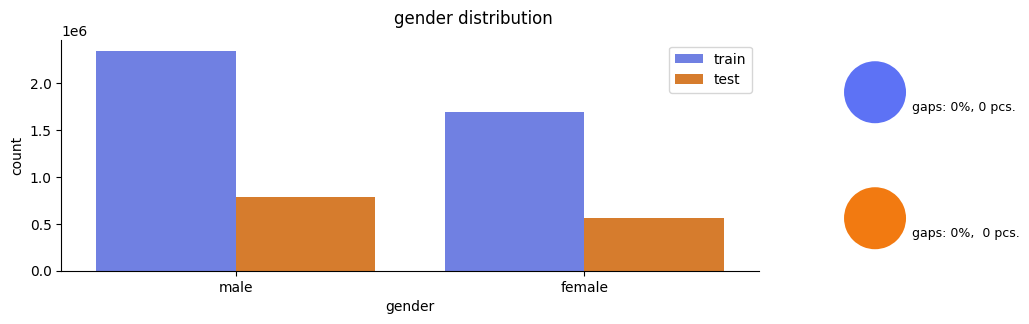

In [91]:
description_cat(train.gender, test.gender)

#### nbki_score

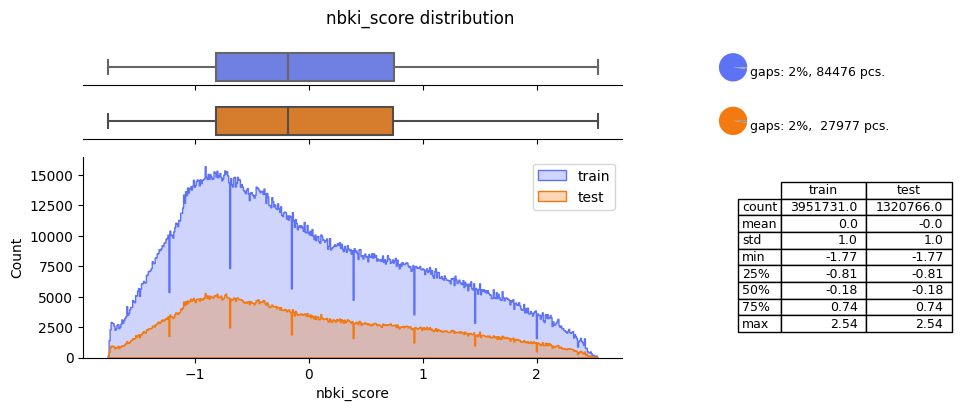

In [92]:
description(train.nbki_score, test.nbki_score)

Выбросов нет.\
2 % пропусков, возможно, связаны с тем что у людей нет кридитной истории. Заполним среднем.

In [93]:
nbki_score_mean = train.nbki_score.mean()

train.nbki_score.fillna(nbki_score_mean, inplace=True)
test. nbki_score.fillna(nbki_score_mean, inplace=True)

#### loan_id

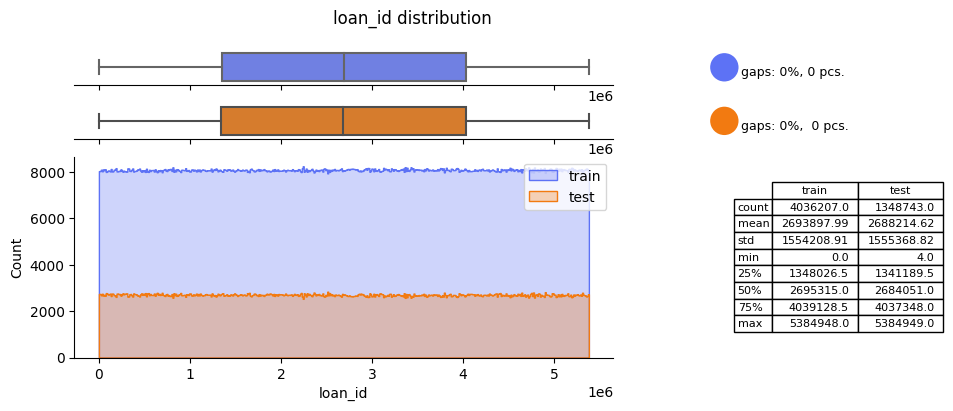

In [94]:
description(train.loan_id, test.loan_id)

In [95]:
train.loan_id.duplicated().sum()

0

In [96]:
test.loan_id.duplicated().sum()

0

In [97]:
train.shape[0]+test.shape[0] # общее число объектов в train и test

5384950

Значения идут подряд без пропусков и дубликатов. Общее количество (за вычетом 1, т.к. нумерация с 0) равно максимальному значению.

#### client_id

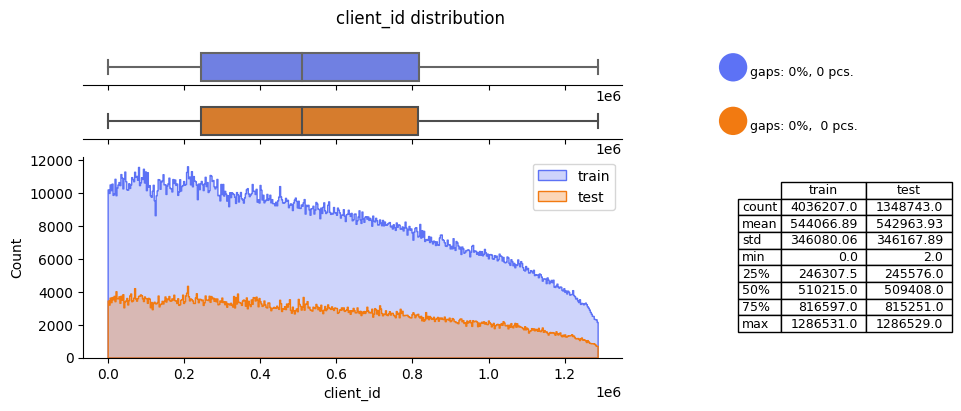

In [98]:
description(train.client_id, test.client_id)

Гистограмма идёт по убывающей, т.к. более ранние (старые) клиенты успели взять больше кредитов и записей с ними больше.

#### loan_order

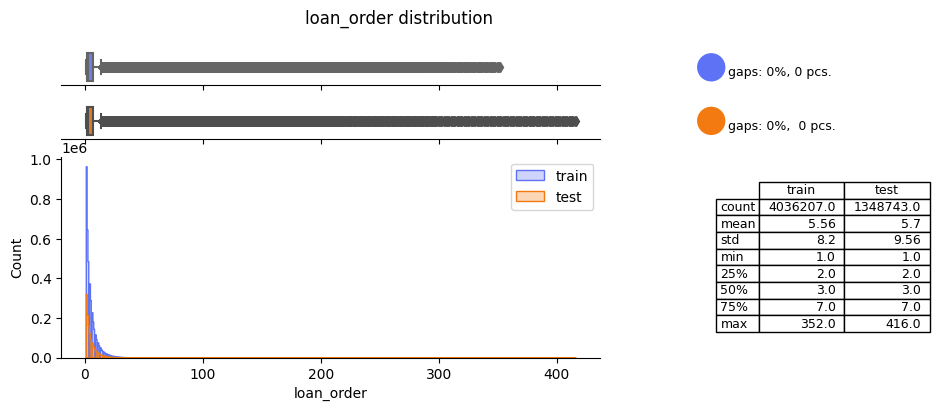

In [99]:
description(train.loan_order, test.loan_order)

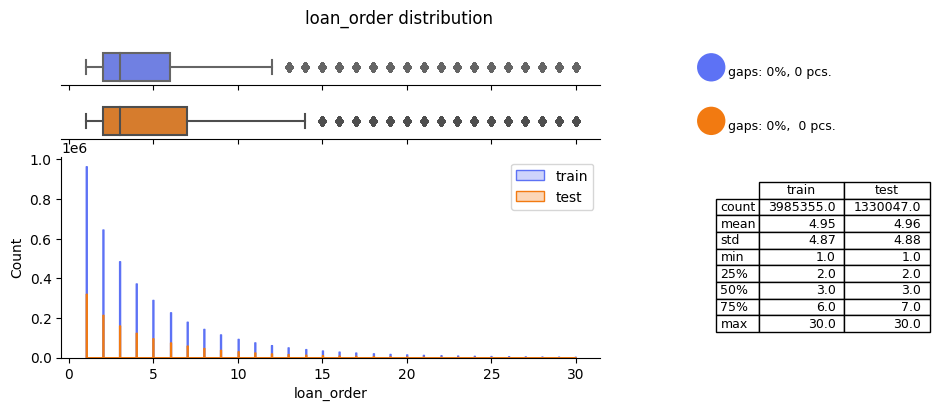

In [100]:
description(train.loan_order[train.loan_order<=30], test.loan_order[test.loan_order<=30])

In [101]:
(train.loan_order>30).mean().round(2) # доля выбросов >30 в train

0.01

In [102]:
(test.loan_order>30).mean().round(2) # доля выбросов >30 в test

0.01

Предположим, что поведение клиента в плане оттока не будет сильно отличаться взял он 30 раз кредит или 300. И то и другое - много.\
Обрежем максимум до 30 раз.

In [103]:
train.loc[train.loan_order>30, 'loan_order'] = 30
test. loc[test. loan_order>30, 'loan_order'] = 30

#### client_type & client_type.1

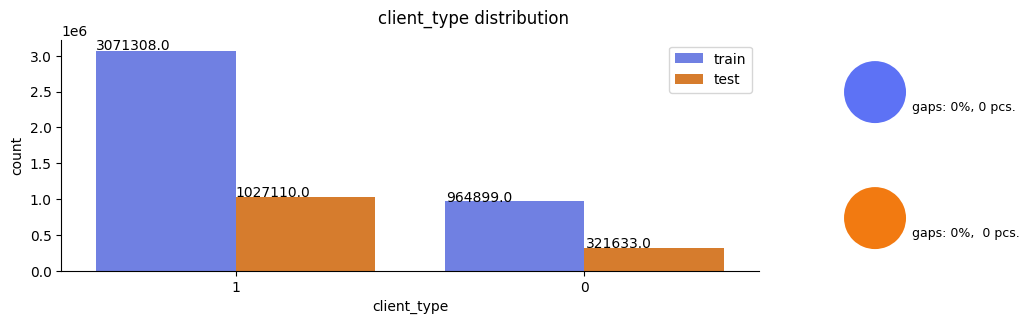

In [104]:
description_cat(train.client_type, test.client_type, values=True)

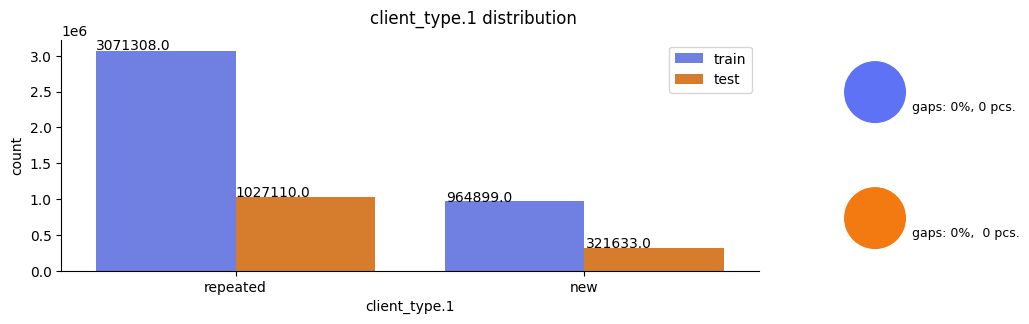

In [105]:
description_cat(train['client_type.1'], test['client_type.1'], values=True)

`client_type` & `client_type.1` - идентичные признаки, только `client_type` уже закодирован.

Проверка, нет ли пересечений, когда в `loan_order` клиент считается новым (1), а в `client_type.1` повторным (repeated):

In [106]:
train.query("`client_type.1` == 'repeated' & loan_order == 1").shape[0]

0

#### contact_cases

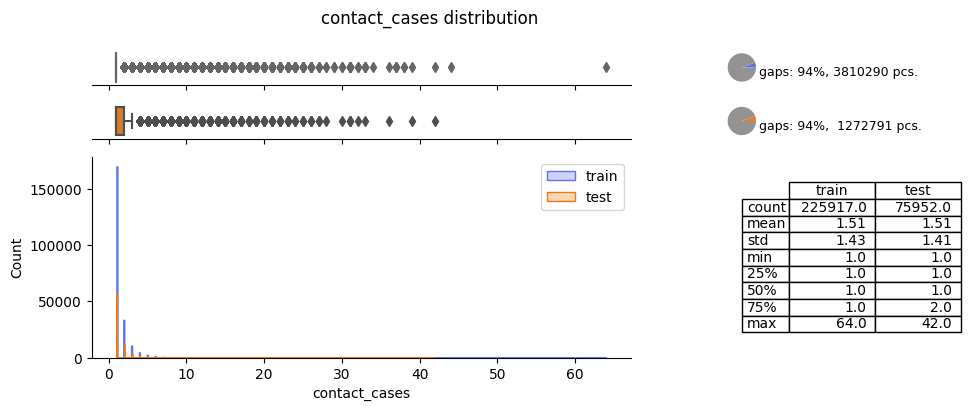

In [107]:
description(train.contact_cases, test.contact_cases)

In [108]:
train.contact_cases.value_counts(normalize=True).round(3).head(6) # доли каждого числа обращений

contact_cases
1.0    0.752
2.0    0.149
3.0    0.048
4.0    0.021
5.0    0.011
6.0    0.006
Name: proportion, dtype: float64

In [109]:
(train.contact_cases>3).mean().round(3) # доля выбросов больше 3

0.003

In [110]:
# выбросы >3 приравниваем к 3
train.loc[train.contact_cases>3, 'contact_cases'] = 3
test.loc [test. contact_cases>3, 'contact_cases'] = 3

Предположим, что пропуски соответствуют отсутствию обращения. Заполним нулями.

In [111]:
train.contact_cases.fillna(0, inplace=True)
test. contact_cases.fillna(0, inplace=True)

#### payment_frequency

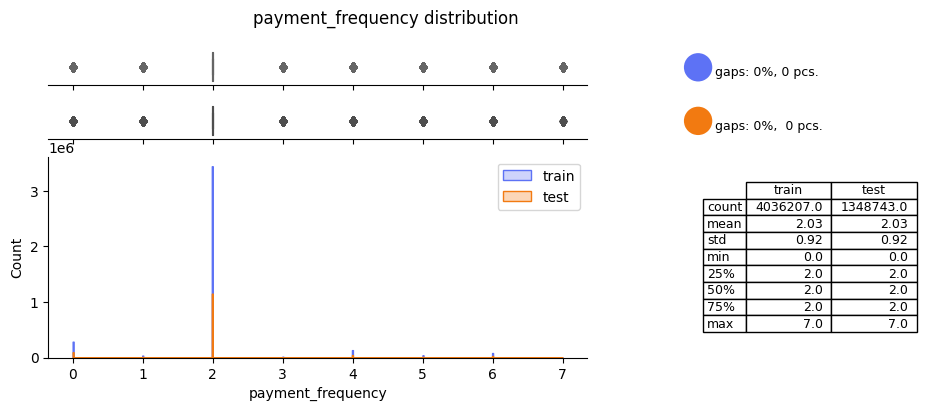

In [112]:
description(train.payment_frequency, test.payment_frequency)

Зарплату чаще всего получают 2 раза в месяц.

#### work_experience

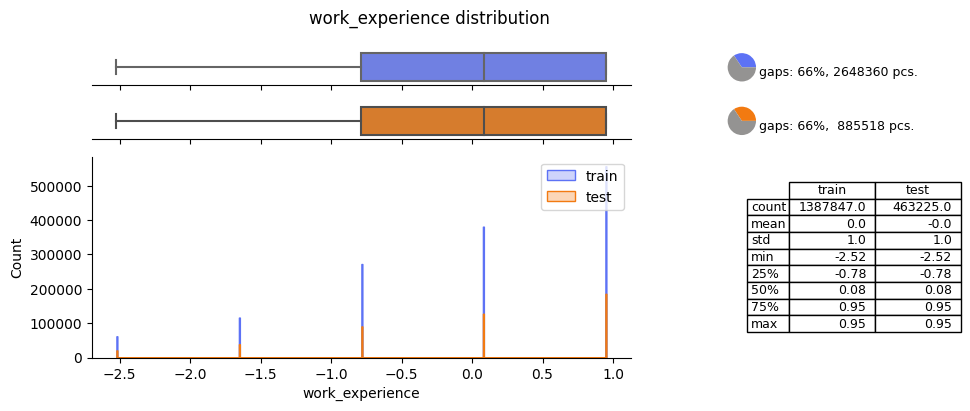

In [113]:
description(train.work_experience, test.work_experience)

Много пропусков. 2 варианта: либо опыта нет, либо информация отсутствует.\
Посмотрим на распределение возраста при отсутствующем опыте.

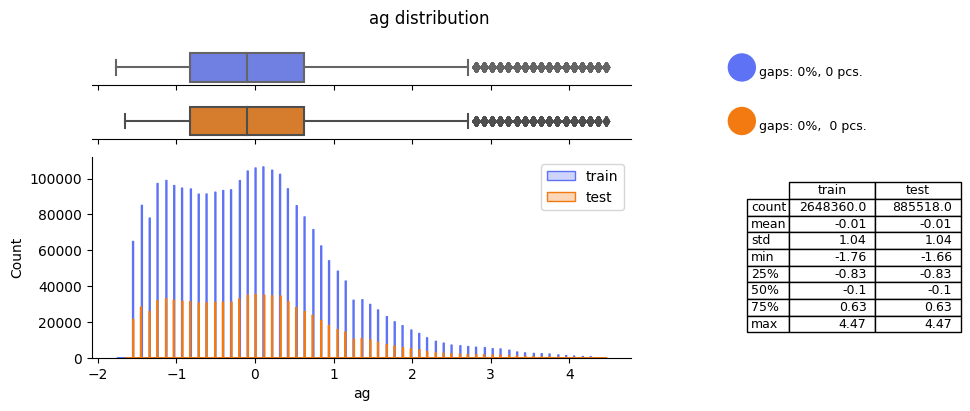

In [114]:
description(train.ag[train.work_experience.isna()], 
            test. ag[test. work_experience.isna()])

Распределение такое же, как и по всем объектам. Т.е все возрастные группы не есть в пропусках по опыту.
Значит информация неизвеста.

Проверим коррелирует ли заполнение этого признака с целевым.

In [115]:
train.churn[train.work_experience.isna()].mean().round(2) # доля оттока в пропусках

0.29

In [116]:
train.churn[~train.work_experience.isna()].mean().round(2) # доля оттока в НЕпропусках

0.29

Явной связи нет.

Заполним средним.

In [117]:
work_experience_mean = train.work_experience.mean()

train.work_experience.fillna(work_experience_mean, inplace=True)
test. work_experience.fillna(work_experience_mean, inplace=True)

Признак практически стандартизован. Можно не проводить стандартизацию.

#### source

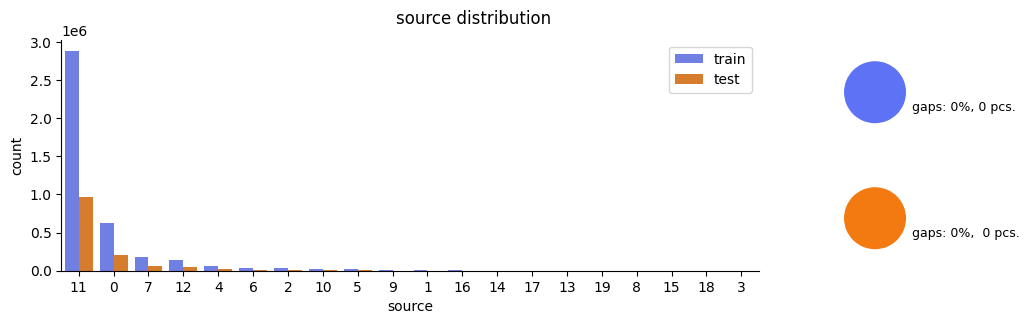

In [118]:
description_cat(train.source, test.source)

#### first_source

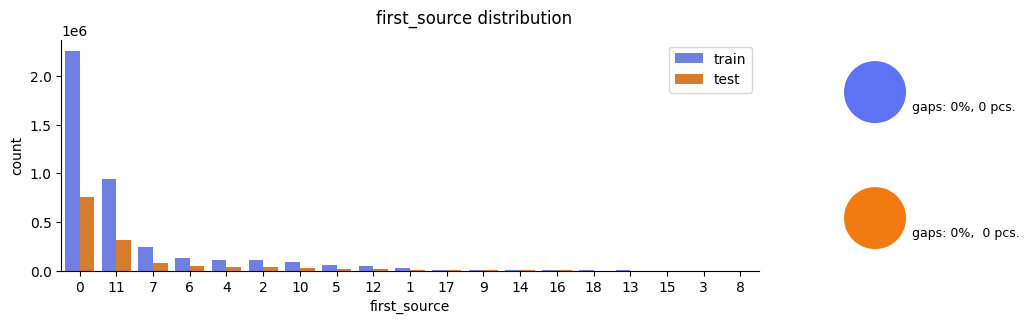

In [119]:
description_cat(train.first_source, test.first_source)

`source` & `first_source` - категориальные признаки.\
В 1-ом на 1 признак больше.\
Одинаковая ли кодировка неизвестно.

#### interface

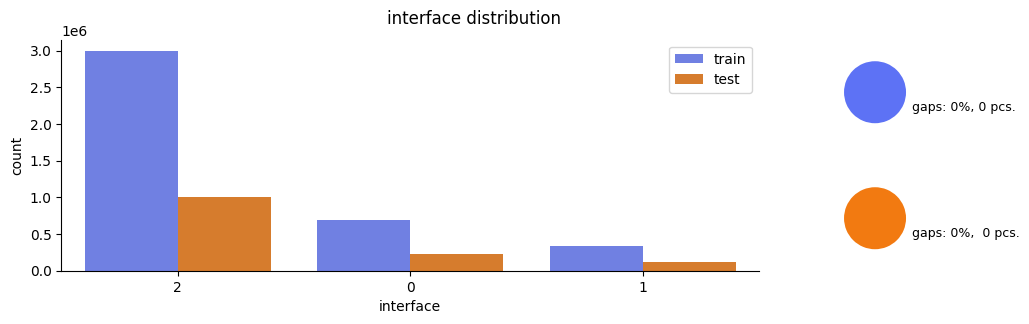

In [120]:
description_cat(train.interface, test.interface)

#### type

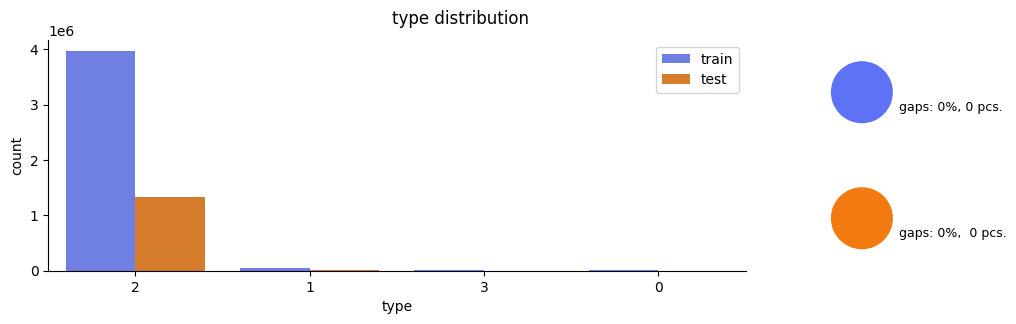

In [121]:
description_cat(train.type, test.type)

#### repayment_type

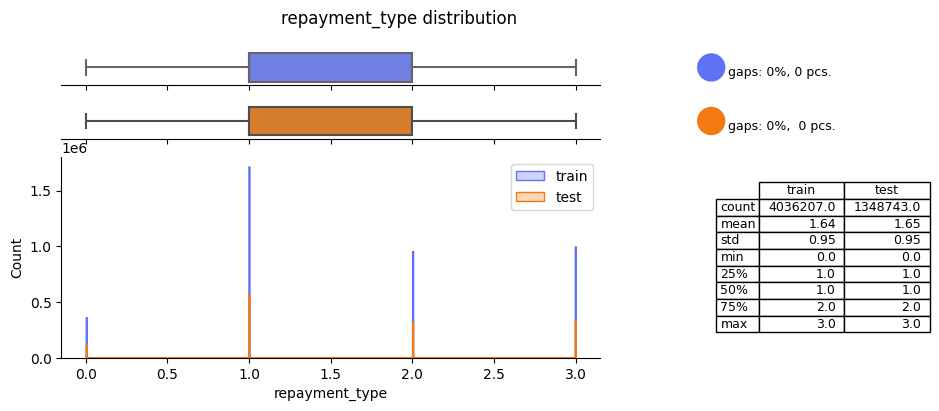

In [122]:
description(train.repayment_type, test.repayment_type)

Скорее всего, при кодировке сохранилась очерёдность от меньшего к большему проценту.\
Используем, как количественный признак. Потом, для эксперимента, можно попробовать в качестве категориального.

#### have_extension

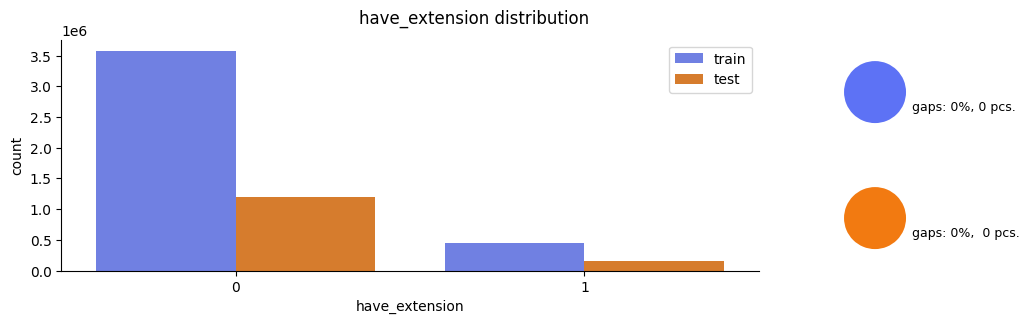

In [123]:
description_cat(train.have_extension, test.have_extension)

#### cnt_ext

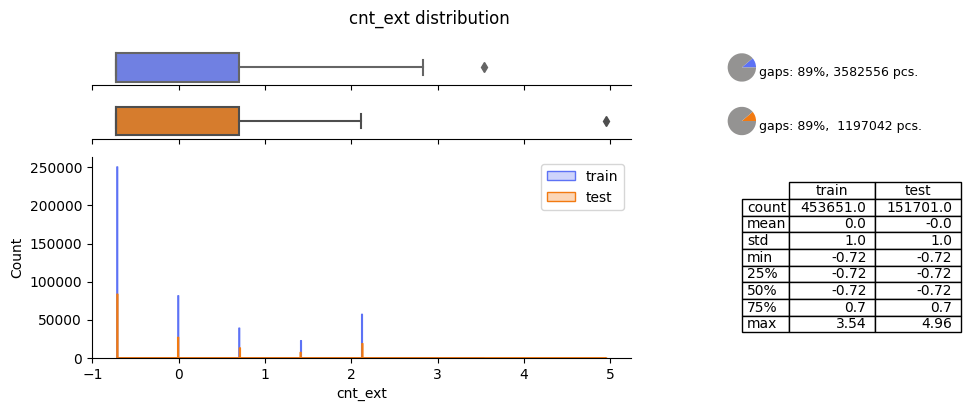

In [124]:
description(train.cnt_ext, test.cnt_ext)

Проверим коррелирует ли заполнение этого признака с целевым.

In [125]:
train.churn[train.cnt_ext.isna()].mean().round(2) # доля оттока в пропусках

0.29

In [126]:
train.churn[~train.cnt_ext.isna()].mean().round(2) # доля оттока в НЕпропусках

0.29

Явной связи нет.

Скорее всего, пропуск соответсвует нулю пролонгаций. Но признак уже нормализован.\
Ноль пролонгаций на этой шкале будет в районе -1.5.

In [127]:
train.cnt_ext.fillna(-1.5, inplace=True)
test. cnt_ext.fillna(-1.5, inplace=True)

#### term

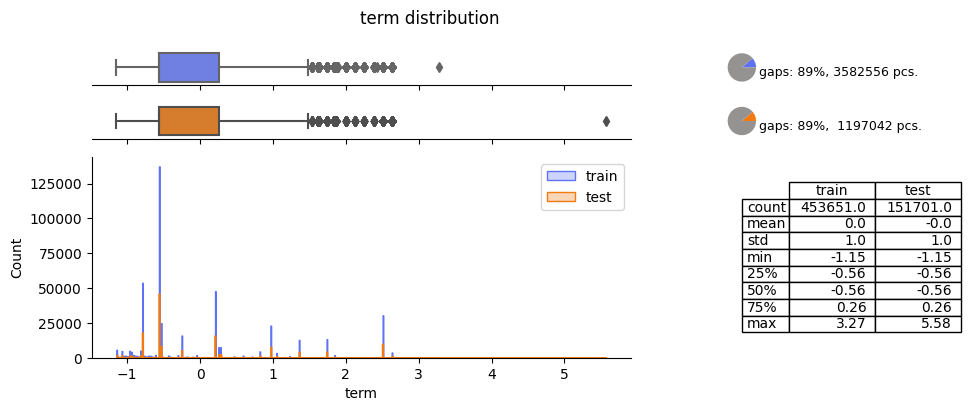

In [128]:
description(train.term, test.term)

Скорее всего, пропуск соответсвует нулю пролонгаций. Но признак уже нормализован.\
Ноль пролонгаций на этой шкале будет в районе -1.5.

In [129]:
train.term.fillna(-1.5, inplace=True)
test. term.fillna(-1.5, inplace=True)

#### requested_period_days

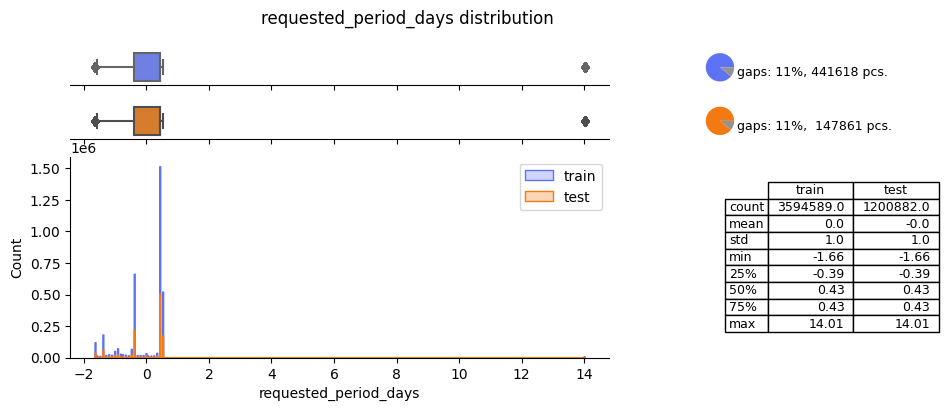

In [130]:
description(train.requested_period_days, test.requested_period_days)

In [131]:
(train.requested_period_days>1).mean().round(3) # доля выбросов > 1

0.003

In [132]:
# урезаем выбросы до 1
train.loc[train.requested_period_days>1, 'requested_period_days'] = 1
test. loc[test. requested_period_days>1, 'requested_period_days'] = 1

Пропуски заполним средним.

In [133]:
requested_period_days_mean = train.requested_period_days.mean()

train.requested_period_days.fillna(requested_period_days_mean, inplace=True)
test. requested_period_days.fillna(requested_period_days_mean, inplace=True)

#### main_agreement_term

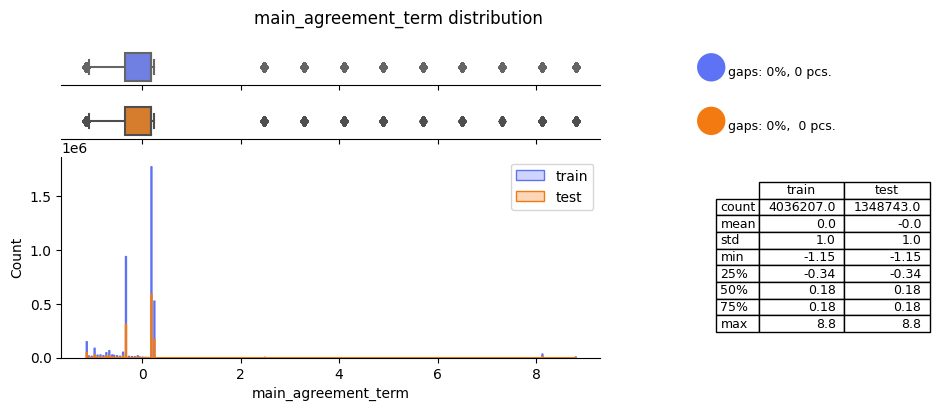

In [134]:
description(train.main_agreement_term, test.main_agreement_term)

In [135]:
(train.main_agreement_term>1).mean().round(3) # доля выбросов > 1

0.014

In [136]:
# урезаем выбросы до 1
train.loc[train.main_agreement_term>1, 'main_agreement_term'] = 1
test. loc[test. main_agreement_term>1, 'main_agreement_term'] = 1

#### period_days

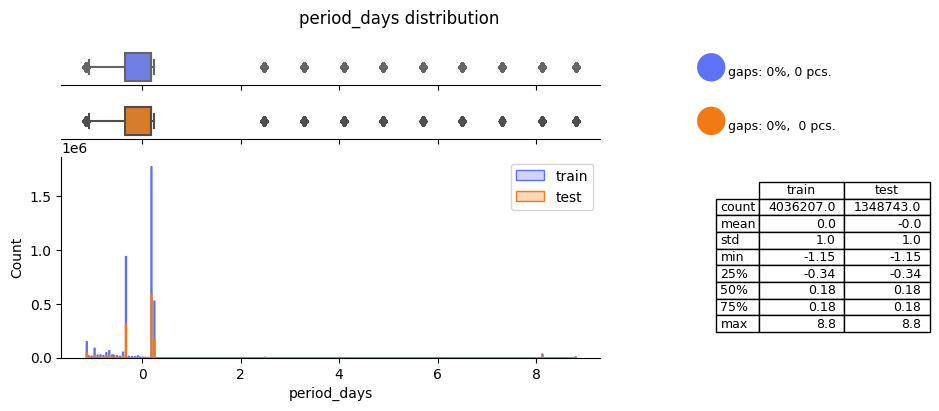

In [137]:
description(train.period_days, test.period_days)

In [138]:
(train.period_days>1).mean().round(3) # доля выбросов > 1

0.014

In [139]:
# урезаем выбросы до 1
train.loc[train.period_days>1, 'period_days'] = 1
test. loc[test. period_days>1, 'period_days'] = 1

#### created_at

In [140]:
train.created_at.head(3)

0    2022-12-23 17:50:25
1    2024-06-29 22:26:08
2    2023-04-10 21:06:38
Name: created_at, dtype: object

In [141]:
train.created_at.apply(lambda x: type(x)).unique()   # тип данных; проверка всех объектов

array([<class 'str'>], dtype=object)

In [142]:
# преобразование строчного формата в datetime
train.created_at = pd.to_datetime(train.created_at, format='%Y-%m-%d %H:%M:%S')
test. created_at = pd.to_datetime(test. created_at, format='%Y-%m-%d %H:%M:%S')
train.created_at.head()

0   2022-12-23 17:50:25
1   2024-06-29 22:26:08
2   2023-04-10 21:06:38
3   2023-10-01 00:13:16
4   2024-07-15 10:40:35
Name: created_at, dtype: datetime64[ns]

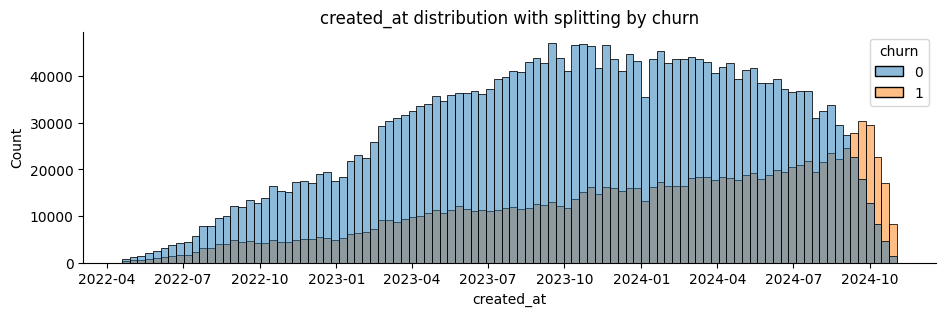

In [143]:
plt.figure(figsize=(11,3))
sns.histplot(data=train, x='created_at', hue='churn', bins=100)
plt.title('created_at distribution with splitting by churn')
sns.despine()

Видим пропорциональную динамику роста оттока и НЕоттока до начала 09.2023.\
Далее число оттока продолжает увеличиваться, НЕоттока уменьшаться.\
Скорее всего, связано с тем, что пока не подошёл срок возврата займа и в базе данных это фиксируется, как 1 (отток).\
Менее вероятный вариант, что с осени 2023 люди действительно стали чаще уходить (не возвращать займ).

В любом случае `timeline` - важный признак и он явно влияет на целевой.
Создадим новый признак - время в формате unix.

Также создадим: месяц, дату, день недели. Мало вероятно, что они влиятельные на целевой. Но посмотрим в матрице корреляции.

In [144]:
train['created_at_month']   = train['created_at'].dt.month
train['created_at_date']    = train['created_at'].dt.day
train['created_at_weekday'] = train['created_at'].dt.weekday
train['created_at_unix']    = train['created_at'].apply(lambda x: x.timestamp())

test ['created_at_month']   = test ['created_at'].dt.month
test ['created_at_date']    = test ['created_at'].dt.day
test ['created_at_weekday'] = test ['created_at'].dt.weekday
test ['created_at_unix']    = test ['created_at'].apply(lambda x: x.timestamp())

#### closed_at

Признак отсутствует в `test`.

In [145]:
train.closed_at.head(3)

0    2022-12-31 16:09:23
1    2024-07-27 16:21:49
2    2023-05-10 07:51:18
Name: closed_at, dtype: object

In [146]:
train.closed_at.apply(lambda x: type(x)).unique()   # тип данных; проверка всех объектов

array([<class 'str'>], dtype=object)

In [147]:
# преобразование строчного формата в datetime
train.closed_at = pd.to_datetime(train.closed_at, format='%Y-%m-%d %H:%M:%S')
train.closed_at.head()

0   2022-12-31 16:09:23
1   2024-07-27 16:21:49
2   2023-05-10 07:51:18
3   2024-01-12 17:40:14
4   2024-07-18 12:20:08
Name: closed_at, dtype: datetime64[ns]

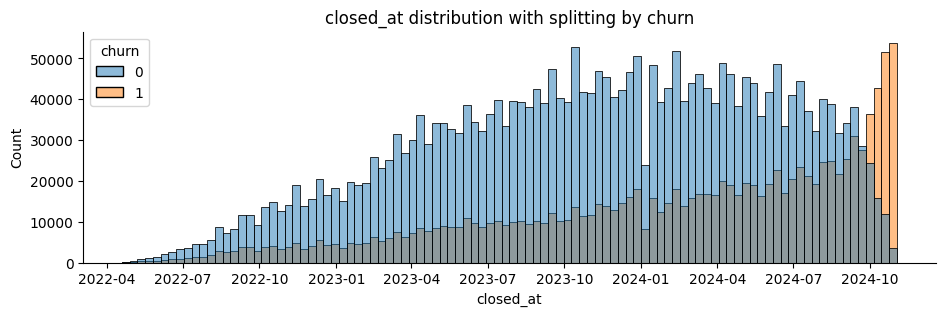

In [148]:
plt.figure(figsize=(11,3))
sns.histplot(data=train, x='closed_at', hue='churn', bins=100)
plt.title('closed_at distribution with splitting by churn')
sns.despine()

#### days_finish_loan

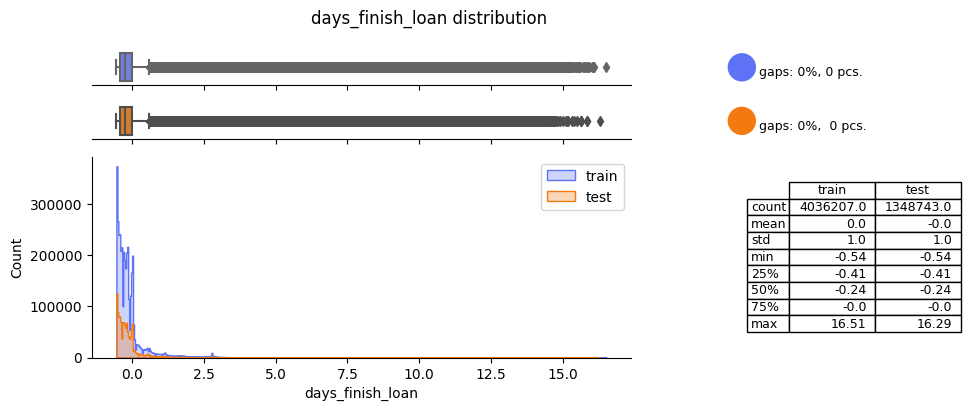

In [149]:
description(train.days_finish_loan, test.days_finish_loan)

In [150]:
# интервал от открытия до закрытия в днях
train['days_finish_loan_days'] = (train.closed_at-train.created_at).dt.days

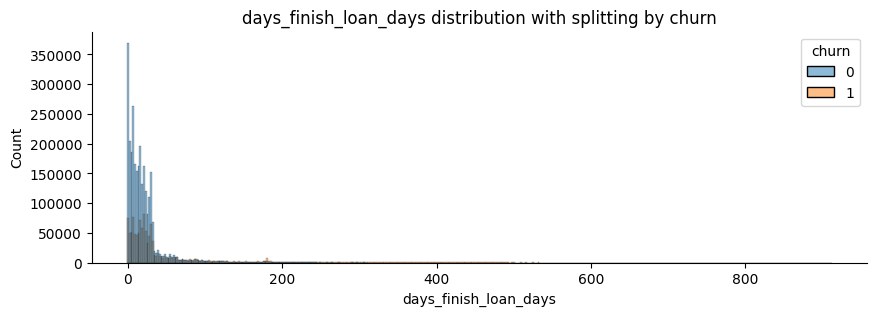

In [151]:
distribution(train, 'days_finish_loan_days')

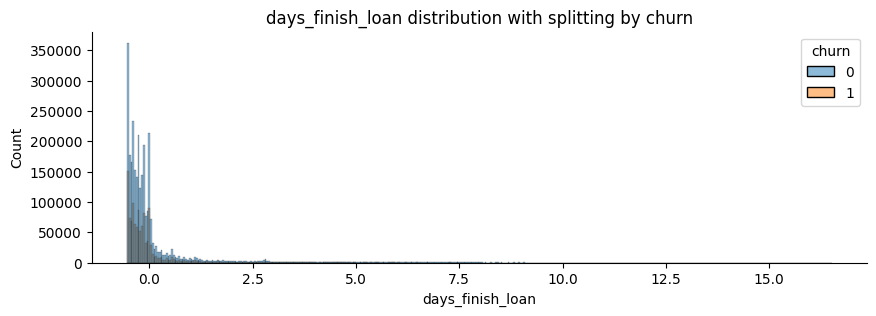

In [152]:
distribution(train, 'days_finish_loan')

На графиках выше видна разная динамика с увеличением срока по соотношению оттока и НЕоттока.\
В графике, где шкала x в днях заметно увеличение доли оттока с ростом срока заёма.\
В графике, где шкала x нормализована соотношение оттока к НЕоттоку не меняется.

Ниже представлены те же графике, но в другом масштабе для большей наглядности (левая и правая части графиков).

Левая часть:

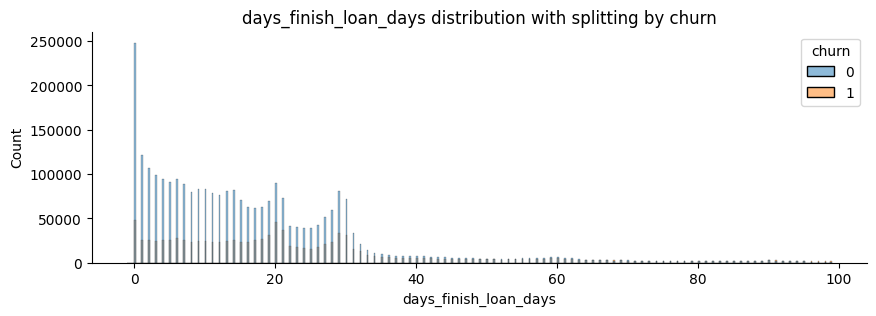

In [153]:
distribution(train[train.days_finish_loan_days<100], 'days_finish_loan_days')

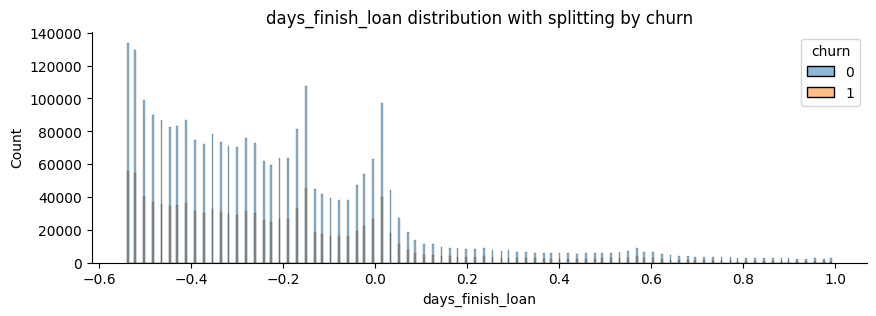

In [154]:
distribution(train[train.days_finish_loan<1], 'days_finish_loan')

Правая часть:

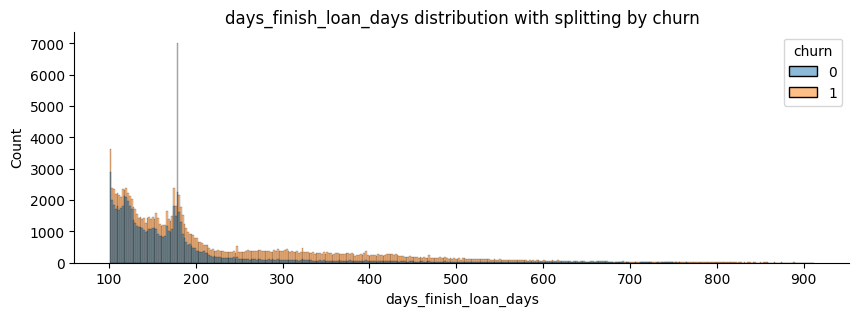

In [155]:
distribution(train[train.days_finish_loan_days>100], 'days_finish_loan_days')

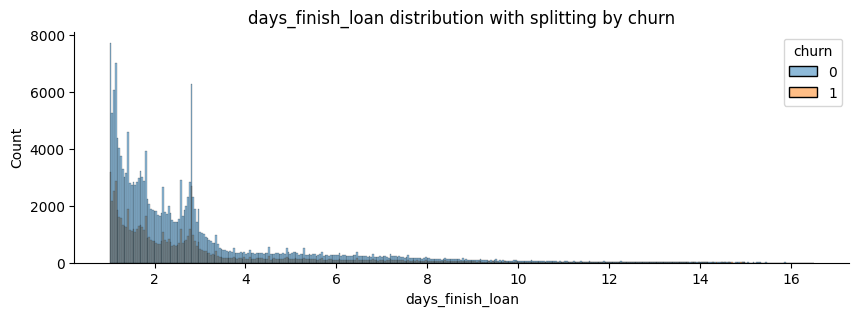

In [156]:
distribution(train[train.days_finish_loan>1], 'days_finish_loan')

Эксперимент. Нормализуем данные в днях.

In [157]:
train['days_finish_loan_days_norm'] = \
(train['days_finish_loan_days']-train['days_finish_loan_days'].mean())/train['days_finish_loan_days'].std()

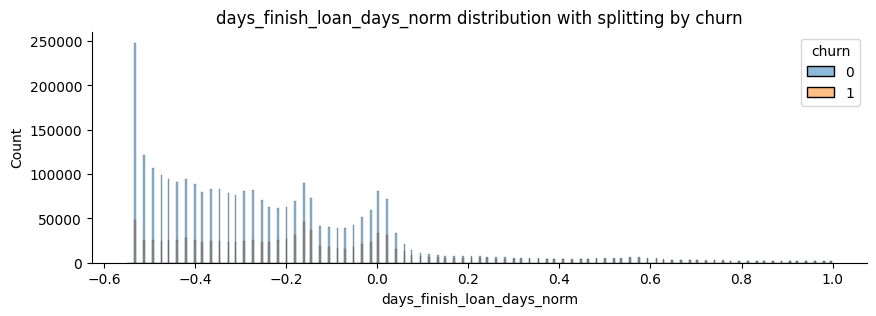

In [158]:
distribution(train[train.days_finish_loan_days_norm<1], 'days_finish_loan_days_norm')

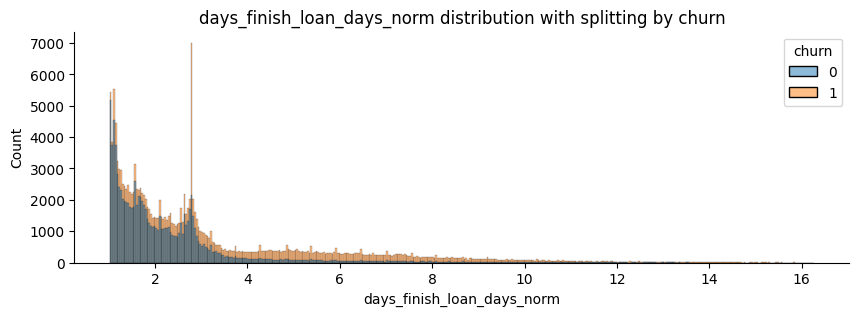

In [159]:
distribution(train[train.days_finish_loan_days_norm>1], 'days_finish_loan_days_norm')

Нормализованные данные сохранили такую же взаимосвязь с churn.\
Таким образом, исходный нормализованный признак закодирован как-то специфично чтобы не сохранить зависимость от целевого.

Эксперимент 2. Попробуем исходные нормализованные данные перевести в дни.

In [160]:
mean_days = train['days_finish_loan_days'].mean()
std_days  = train['days_finish_loan_days'].std()

train['days_finish_loan_inverse_to_days'] = train['days_finish_loan']*std_days+mean_days

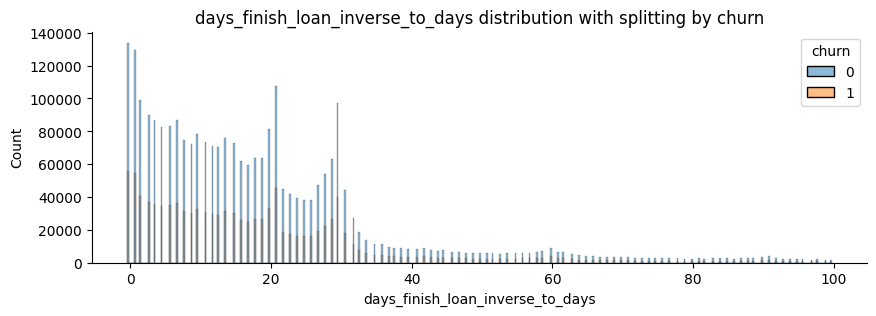

In [161]:
distribution(train[train.days_finish_loan_inverse_to_days<100], 'days_finish_loan_inverse_to_days')

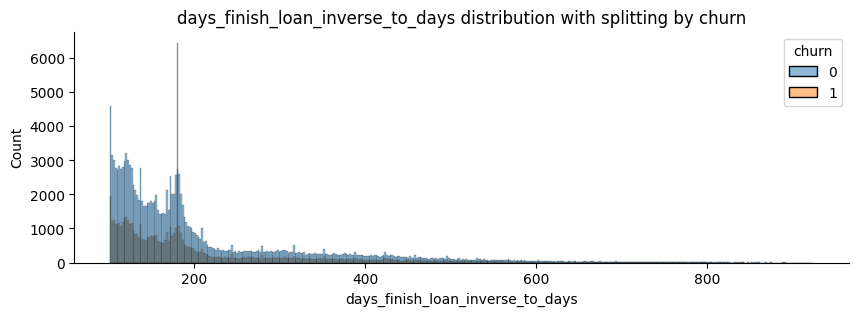

In [162]:
distribution(train[train.days_finish_loan_inverse_to_days>100], 'days_finish_loan_inverse_to_days')

Полученное распределение в днях идентично нормализованному распределению.

Признак странный. Есть сомнение, что он действительно создан из разницы `closed_at` и `created_at`.

Удалим экспериментальные столбцы.

In [163]:
train.drop(['days_finish_loan_days', 
            'days_finish_loan_days_norm',
            'days_finish_loan_inverse_to_days'], axis=1, inplace=True)

Вернёмся к обработке исходного признака.

In [164]:
(train.days_finish_loan>4).mean().round(3)  # доля значений > 4

0.013

In [165]:
# выбросы > 4 приравниваем к 4
train.loc[train.days_finish_loan>4, 'days_finish_loan'] = 4
test. loc[test. days_finish_loan>4, 'days_finish_loan'] = 4

#### start_dt

In [166]:
train.start_dt.head()

0                    NaN
1                    NaN
2                    NaN
3    2024-01-12 17:29:21
4                    NaN
Name: start_dt, dtype: object

In [167]:
train.start_dt.apply(lambda x: type(x)).unique()   # тип данных; проверка всех объектов

array([<class 'float'>, <class 'str'>], dtype=object)

In [168]:
# преобразование строчного формата в datetime
train.start_dt = pd.to_datetime(train.start_dt, format='%Y-%m-%d %H:%M:%S')
test. start_dt = pd.to_datetime(test. start_dt, format='%Y-%m-%d %H:%M:%S')
train.start_dt.head()

0                   NaT
1                   NaT
2                   NaT
3   2024-01-12 17:29:21
4                   NaT
Name: start_dt, dtype: datetime64[ns]

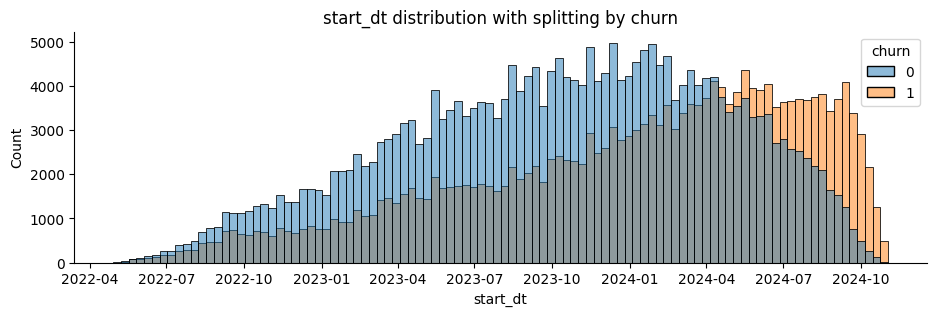

In [169]:
plt.figure(figsize=(11,3))
sns.histplot(data=train, x='start_dt', hue='churn', bins=100)
plt.title('start_dt distribution with splitting by churn')
sns.despine()

Признак может быть полезен, т.к. наблюдается зависимость churn от timeline.\
Но много пропусков - 89%. Чем заполнять?\
Если взять какое-то значение вначале, модель будет ставить чаще 0; в конце - 1.\
Заполним пропуски моментом перелома - где число 0 примерно равно числу 1.

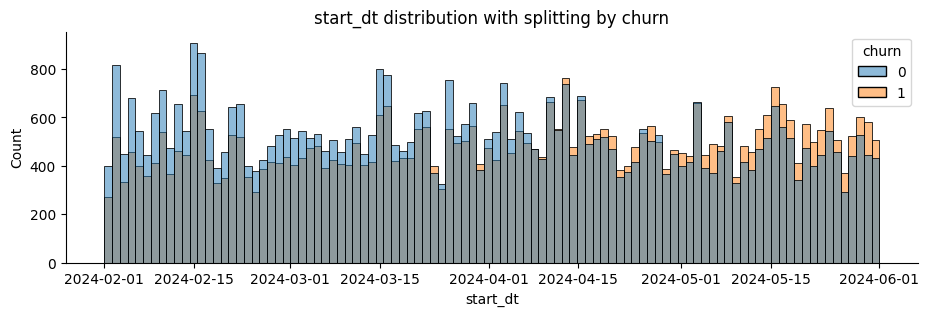

In [170]:
plt.figure(figsize=(11,3))
sns.histplot(data=train[(train.start_dt>'2024-02-01') & (train.start_dt<'2024-06-01')], 
             x='start_dt', hue='churn', bins=100)
plt.title('start_dt distribution with splitting by churn')
sns.despine()

Пропуски заполним значением unix, соответствующим '2024-04-08'.

In [171]:
# создаём признак timeline в формате unix
train['start_dt_unix'] = train.loc[~train.start_dt.isna(), 'start_dt'].apply(lambda x: x.timestamp())
test ['start_dt_unix'] = test. loc[~test. start_dt.isna(), 'start_dt'].apply(lambda x: x.timestamp())

In [172]:
start_dt_unix_fracture_time = pd.to_datetime('2024-04-08').timestamp()

train.start_dt_unix.fillna(start_dt_unix_fracture_time, inplace=True)
test. start_dt_unix.fillna(start_dt_unix_fracture_time, inplace=True)

#### region

In [173]:
train.region.head()

0         г Москва
1         г Москва
2    край Пермский
3    обл Самарская
4         г Москва
Name: region, dtype: object

In [174]:
train.region.nunique()

189

In [175]:
sorted(train.region.unique())

['АО Ненецкий',
 'АО Ханты-Мансийский',
 'АО Ханты-Мансийский Автономный округ - Югра',
 'АО Чукотский',
 'АО Ямало-Ненецкий',
 'Алтайский край Алтайский',
 'Амурская обл Амурская',
 'Аобл Еврейская',
 'Архангельская обл Архангельская',
 'Астраханская обл Астраханская',
 'Белгородская обл Белгородская',
 'Брянская обл Брянская',
 'Владимирская обл Владимирская',
 'Волгоградская обл Волгоградская',
 'Вологодская обл Вологодская',
 'Воронежская обл Воронежская',
 'Еврейская Аобл Еврейская',
 'Забайкальский край Забайкальский',
 'Ивановская обл Ивановская',
 'Иркутская обл Иркутская',
 'Кабардино-Балкарская Респ Кабардино-Балкарская',
 'Калининградская обл Калининградская',
 'Калужская обл Калужская',
 'Камчатский край Камчатский',
 'Карачаево-Черкесская Респ Карачаево-Черкесская',
 'Кемеровская область - Кузбасс Кемеровская область - Кузбасс',
 'Кировская обл Кировская',
 'Костромская обл Костромская',
 'Краснодарский край Краснодарский',
 'Красноярский край Красноярский',
 'Курганская о

In [176]:
train.region = train.region.str.lower()         # перевод в нижний регистр 
test. region = test. region.str.lower()

In [177]:
# убираем незначимые слова и удаляем пробелы с краёв
pattern = 'г |край|респ |республика|ао |аобл|обл |область|район|автономный округ|народная|автономная|кузбасс| -|- |югра|автономный|окру-|якутия|\(|\)|/'
train.region = train.region.apply(lambda x: re.sub(pattern, '', x).strip())
test. region = test. region.apply(lambda x: re.sub(pattern, '', x).strip())

In [178]:
# убираем дубликаты в строках
train.region = train.region.apply(lambda x: ' '.join(sorted(list(set(x.split())))))
test. region = test. region.apply(lambda x: ' '.join(sorted(list(set(x.split())))))

In [179]:
# обработка дубликатов вручную
for df in (train, test):
    df.region.replace(['чувашия чувашская','чувашская чувашия'], 'чувашия',         inplace=True)
    df.region.replace('санкт-петербурсанкт-петербург',           'санкт-петербург', inplace=True)
    df.region.replace('сахалин',                                 'сахалинская',     inplace=True)

In [180]:
pivot_table_region = train.pivot_table(index='region', 
                                       values='churn',
                                       aggfunc=['count','mean']).sort_values(('count', 'churn'),
                                                                             ascending=False)
pivot_table_region.columns = ['count_churn', 'mean_churn']

In [181]:
pivot_table_region.head()

count_churn  mean_churn
region                                  
москва                270106    0.281527
московская            266380    0.277817
краснодарский         182417    0.296047
свердловская          153247    0.287523
санкт-петербург       137614    0.287311

In [182]:
pivot_table_region.shape[0]

89

In [183]:
def mean_churn_scatter(data=pivot_table_region, xlim=None, ylim=None):
    data.plot(x='count_churn', y='mean_churn', figsize=(11,3), style='x', grid=True)
    plt.title('mean churn scatter by location')
    plt.xlabel('amount of customers in the location')
    sns.despine(); plt.xlim(xlim); plt.ylim(ylim)

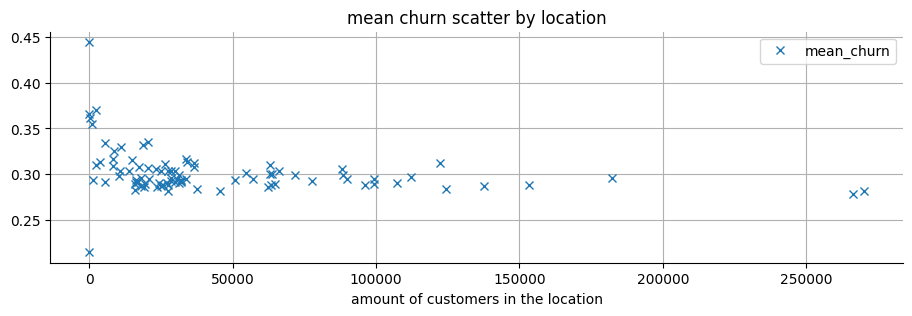

In [184]:
mean_churn_scatter()

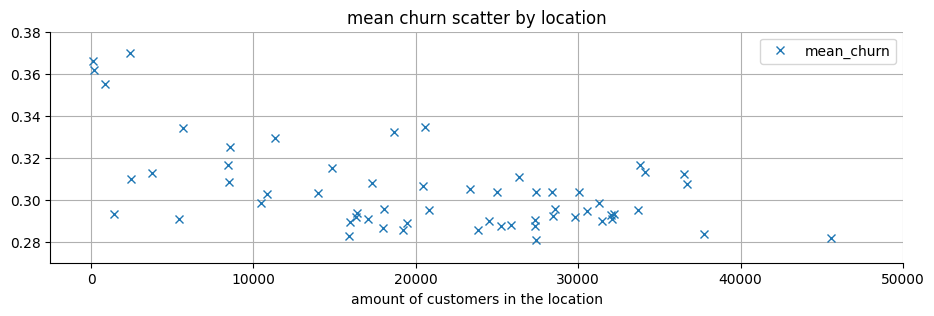

In [185]:
mean_churn_scatter(xlim=(-2500,50000), ylim=(0.27, 0.38))

Видим, что регион влияет на целевой признак.

#### settlement

In [186]:
train.settlement.head()

0    г Москва
1    г Москва
2     г Пермь
3    г Самара
4    г Москва
Name: settlement, dtype: object

In [187]:
train.settlement.nunique()

47425

In [188]:
train.settlement = train.settlement.str.lower()         # перевод в нижний регистр 
test. settlement = test. settlement.str.lower()

In [189]:
# убираем незначимые слова и удаляем пробелы с краёв
pattern = 'г |рп |поселок|пгт |село|гп |имени |им |деревня|город|мкр |квартал|р-н |хутор|ж/д_ст|ст-ца|ст |аул |снт|тер. |жк |\(|\)|- | -|'

train.settlement = train.settlement.apply(lambda x: re.sub(pattern, '', x).strip())
test. settlement = test. settlement.apply(lambda x: re.sub(pattern, '', x).strip())

In [190]:
# убираем дубликаты в строках (если есть, не уверен)
train.settlement = train.settlement.apply(lambda x: ' '.join(sorted(list(set(x.split())))))
test. settlement = test. settlement.apply(lambda x: ' '.join(sorted(list(set(x.split())))))

In [191]:
train.settlement.nunique()

43252

In [192]:
# новый признак регион + населённый пункт
train['region_settlement'] = train.region+' '+train.settlement
test ['region_settlement'] = test.region +' '+test.settlement
train['region_settlement'].head()

0       москва москва
1       москва москва
2      пермский пермь
3    самарская самара
4       москва москва
Name: region_settlement, dtype: object

In [193]:
pivot_table_region_settlement = train.pivot_table(index='region_settlement', 
                                                  values='churn',
                                                  aggfunc=['count','mean']).sort_values(('count', 'churn'), 
                                                                                        ascending=False)
pivot_table_region_settlement.columns = ['count_churn', 'mean_churn']

In [194]:
pivot_table_region_settlement.head()

count_churn  mean_churn
region_settlement                                       
москва москва                         247269    0.280516
санкт-петербург санкт-петербург       113224    0.287156
новосибирская новосибирск              58199    0.285709
свердловская екатеринбург              53476    0.286446
татарстан казань                       43216    0.284223

In [195]:
pivot_table_region_settlement.shape[0]

53223

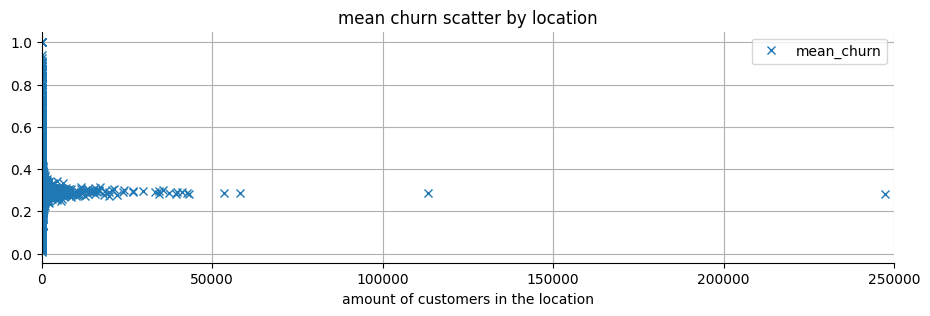

In [196]:
mean_churn_scatter(pivot_table_region_settlement, xlim=(0,250000))

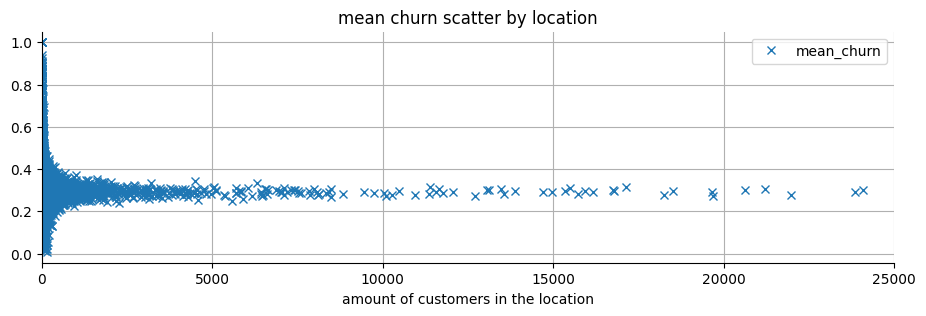

In [197]:
mean_churn_scatter(pivot_table_region_settlement, xlim=(0,25000))

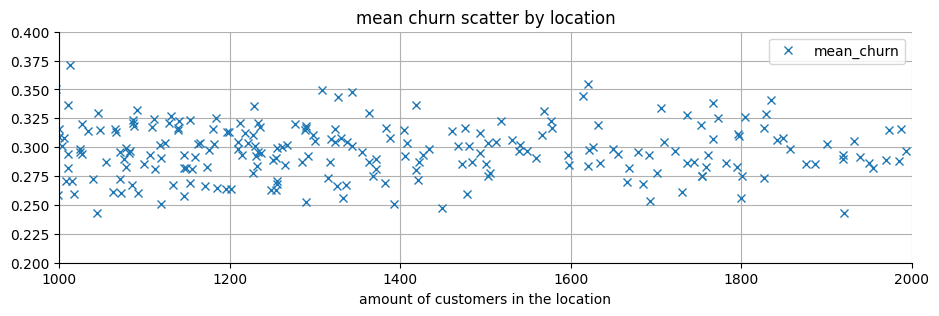

In [198]:
mean_churn_scatter(pivot_table_region_settlement, xlim=(1000,2000), ylim=(0.2,0.4))

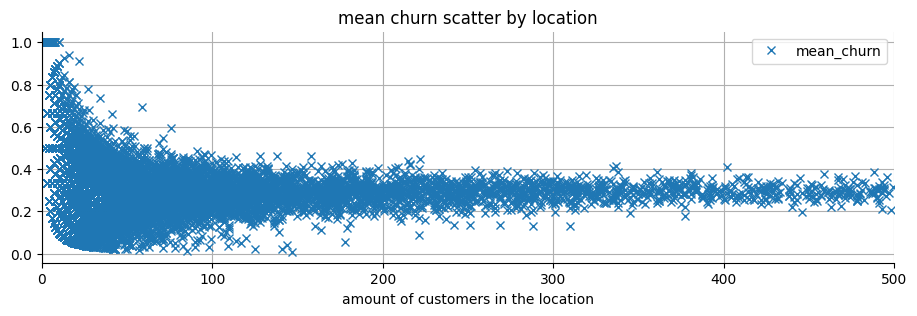

In [199]:
mean_churn_scatter(pivot_table_region_settlement, xlim=(0,500))

Чем больше жителей в населённом пункте, тем среднее оттока больше "устаканивается" и приближается к 29%.\
При меньшем числе жителей разброс в оттоке разных населённых пунктах более заметен.

Для OHE лучше взять как божно больше уникальных локаций. Их около 53000, могут возникнуть проблемы с обработкой данных.\
Прикинем, какую долю объектов мы закроем при разном числе локаций.

In [200]:
print('число локаций для кодирования  |  доля объектов с индивидуально закодированной локацией')
for i in list(range(100,  1000,  100))+\
         list(range(1000, 10000, 1000))+\
         list(range(10000, 50001, 10000)):
    print(f"{i:29}  |{pivot_table_region_settlement[:i].count_churn.sum()/train.shape[0]:6.2f}")

число локаций для кодирования  |  доля объектов с индивидуально закодированной локацией
                          100  |  0.45
                          200  |  0.54
                          300  |  0.58
                          400  |  0.62
                          500  |  0.64
                          600  |  0.66
                          700  |  0.68
                          800  |  0.69
                          900  |  0.70
                         1000  |  0.71
                         2000  |  0.78
                         3000  |  0.82
                         4000  |  0.84
                         5000  |  0.86
                         6000  |  0.88
                         7000  |  0.89
                         8000  |  0.90
                         9000  |  0.91
                        10000  |  0.92
                        20000  |  0.96
                        30000  |  0.98
                        40000  |  1.00
                        50000  |  1.00


#### feature engineering

##### level of regional debt burden

Рейтинг российских регионов по уровню закредитованности населения (начало 2024г.)\
Источник: https://ria.ru/20240311/zakreditovannost-1931419910.html

In [201]:
try:
    level_of_regional_debt_burden = pd.read_excel('level_of_regional_debt_burden.xlsx')
except:
    level_of_regional_debt_burden = pd.read_excel('/kaggle/input/adengi/level_of_regional_debt_burden.xlsx')
level_of_regional_debt_burden.head(7)

Место                      Регион  \
0     1        Республика Ингушетия   
1     2             Республика Крым   
2     3        Чеченская Республика   
3     4         Республика Дагестан   
4     5                 Севастополь   
5     6  Чукотский автономный округ   
6     7                      Москва   

  Соотношение среднедушевого долга по кредитам и годовой зарплаты в начале 2024 года, %  \
0                                               14.9                                      
1                                               29.5                                      
2                                               30.1                                      
3                                               30.7                                      
4                                               31.9                                      
5                                               38.7                                      
6                                               38.8                                      

  Объем задолженности перед банками в среднем на одного человека, тыс. руб.  \
0                                               56.1                          
1                                              143.9                          
2                                              118.5                          
3                                              123.4                          
4                                              158.7                          
5                                              640.2                          
6                                              552.1                          

  Изменение задолженности на одного человека за год, тыс. руб.  
0                                               14.8            
1                                               37.3            
2                                               33.1            
3                                               35.8            
4                                               39.6            
5                                              120.4            
6                                               92.4

In [202]:
level_of_regional_debt_burden.shape

(89, 5)

In [203]:
level_of_regional_debt_burden = level_of_regional_debt_burden[['Место', 'Регион']]
level_of_regional_debt_burden.columns = ['rank','region']
level_of_regional_debt_burden.head(7)

rank                      region
0    1        Республика Ингушетия
1    2             Республика Крым
2    3        Чеченская Республика
3    4         Республика Дагестан
4    5                 Севастополь
5    6  Чукотский автономный округ
6    7                      Москва

In [204]:
level_of_regional_debt_burden.region = level_of_regional_debt_burden.region.str.lower()         # перевод в нижний регистр 

In [205]:
# убираем незначимые слова и удаляем пробелы с краёв
pattern = 'г |край|респ |республика|ао |аобл|обл |область|район|автономный округ|народная|автономная|кузбасс| -|- |югра|автономный|окру-|якутия|\(|\)|/'
level_of_regional_debt_burden.region = level_of_regional_debt_burden.region.apply(lambda x: re.sub(pattern, '', x).strip())

In [206]:
level_of_regional_debt_burden.head()

rank       region
0    1    ингушетия
1    2         крым
2    3    чеченская
3    4     дагестан
4    5  севастополь

In [207]:
level_of_regional_debt_burden.loc[level_of_regional_debt_burden['rank']=='-','rank'] = 100

In [208]:
rating = dict(level_of_regional_debt_burden.set_index('region')['rank'])
rating

{'ингушетия': 1,
 'крым': 2,
 'чеченская': 3,
 'дагестан': 4,
 'севастополь': 5,
 'чукотский': 6,
 'москва': 7,
 'ненецкий': 8,
 'камчатский': 9,
 'магаданская': 10,
 'сахалинская': 11,
 'кабардино-балкарская': 12,
 'мурманская': 13,
 'ямало-ненецкий': 14,
 'санкт-петербург': 15,
 'еврейская': 16,
 'липецкая': 17,
 'владимирская': 18,
 'ярославская': 19,
 'белгородская': 20,
 'самарская': 21,
 'мордовия': 22,
 'нижегородская': 23,
 'волгоградская': 24,
 'кемеровская': 25,
 'саратовская': 26,
 'красноярский': 27,
 'новгородская': 28,
 'челябинская': 29,
 'воронежская': 30,
 'курская': 31,
 'тульская': 32,
 'брянская': 33,
 'томская': 34,
 'иркутская': 35,
 'тамбовская': 36,
 'забайкальский': 37,
 'хабаровский': 38,
 'ханты-мансийский  —': 39,
 'саха': 40,
 'ивановская': 41,
 'марий эл': 42,
 'вологодская': 43,
 'курганская': 44,
 'московская': 45,
 'смоленская': 46,
 'хакасия': 47,
 'ленинградская': 48,
 'калужская': 49,
 'коми': 50,
 'псковская': 51,
 'амурская': 52,
 'ульяновская': 53

In [209]:
train['region_rank'] = train['region'].map(rating)
test ['region_rank'] = test['region'].map(rating)

In [210]:
# регионы рейтинг которых не заполнился
train.region[train.region_rank.isna()].unique()

array(['ханты-мансийский', 'чувашия', 'алания осетия северная'],
      dtype=object)

In [211]:
rating_hand = {
    'ханты-мансийский': 39,
    'чувашия': 75,
    'алания осетия северная': 74}

In [212]:
# дозаполнение
train.loc[train.region_rank.isna(), 'region_rank'] =\
train.loc[train.region_rank.isna(), 'region'].map(rating_hand)

test.loc[test.region_rank.isna(), 'region_rank'] =\
test.loc[test.region_rank.isna(), 'region'].map(rating_hand)

In [213]:
for df in (train,test):
    
    # платёжное поведение
    df['tamount_to_income_ratio']     = df['tamount']  / df['monthly_income']
    df['interest_to_principal_ratio'] = df['interest'] / df['principal']
    df['overdue_ratio']               = (df['overdue_interest'] + df['overdue_fee']) / df['principal']
    df['amount_income']               = df['requested_amount']/df['monthly_income']
    
    # временные характеристики
    df['early_repayment']             = df['period_days'] - df['days_finish_loan']
    
    # кредитное поведение
    df['approval_ratio']              = df['approved_amount'] / df['requested_amount']
    
    # ранее NaN заполнил -1.5; поэтому здесь -1.5 преобразуем в 0, остальное в 1
    df['had_extensions']               = df['cnt_ext'].apply(lambda x: 0 if x==-1.5 else 1)
        
    # признаки рискованности клиента
    df['risk_score'] = (
        (df['nbki_score']     * -1  ) +  # Инвертируем скор, чтобы высокие значения означали высокий риск
        (df['overdue_ratio']  *  2  ) +
        (df['had_extensions'] *  1.5)
        )
    
    # поведенческие признаки
    df['digital_engagement']   = ((df['interface'] == 2) |
                                  (df['source'].isin([11, 12]))).astype(int)
    df['prefers_longer_terms'] = (df['requested_period_days'] >
                                    df['requested_period_days'].mean()).astype(int)
    
    # Финансовая нагрузка
    df['total_debt_burden']       = (df['elecs_sum'] + df['recurents_sum']) / df['monthly_income']

##### financial, behavioral

In [214]:
def client_id_features(df):
    # группируем по client_id и создаем новые признаки
    
    client_features = df.groupby('client_id').agg({
    'loan_id': 'count',          # Общее количество займов
    'days_finish_loan': 'mean',  # Средний срок закрытия займа
    'approved_amount': 'mean',   # Средняя сумма займа
    'cnt_ext': 'sum',            # Общее количество продлений
    'elecs_sum': 'sum',          # Сумма штрафов
    'created_at_unix': 'max',    # Дата последнего займа
    'monthly_income': 'std',     # Вариация дохода
    'contact_cases': 'sum'       # Количество обращений в поддержку
    }).reset_index()

    client_features.rename(columns={
    'loan_id':          'total_loans',
    'days_finish_loan': 'avg_days_finish_loan',
    'approved_amount':  'avg_approved_amount',
    'cnt_ext':          'total_extensions',
    'elecs_sum':        'total_fees',
    'created_at_unix':  'last_loan_date_unix',
    'monthly_income':   'income_variation',
    'contact_cases':    'total_contacts'
    }, inplace=True)
    
    return df.merge(client_features, on='client_id', how='left')

train = client_id_features(train)
test  = client_id_features(test)

In [215]:
# в income_variation пропуски из-за единичности заёма у клиента; заполним
train.income_variation.fillna(0, inplace=True)
test. income_variation.fillna(0, inplace=True)

In [216]:
memory()  # большие объекты в RAM

id  size, MB
variable                                                
train                          138934051753696      4511
test                           138924714011200      1380
df                             138925789677216      1298
sample_submission              138925789690896        20
pivot_table_region_settlement  138922089114512         9

In [217]:
# очистка RAM от ненужных объектов
del df, sample_submission, pivot_table_region_settlement

### Correlation

Определим числовые и категориальные колонки, которые будут в работе:

In [218]:
num_col = ['monthly_income', 
           'work_experience',
           'main_agreement_amount', 
           'main_agreement_term', 
           'requested_period_days',
           'requested_amount', 
           'req_app_amount', 
           'approved_amount', 
           'period_days',
           'days_finish_loan', 
           'ag', 
           'cnt_ext', 
           'term', 
           'price', 
           'elecs_sum',
           'recurents_sum', 
           'tamount', 
           'issues', 
           'principal', 
           'interest',
           'overdue_interest', 
           'overdue_fee', 
           'nbki_score', 
           'payment_frequency',
           'repayment_type', 
           'loan_order', 
           'contact_cases',
           'created_at_month',
           'created_at_date', 
           'created_at_weekday', 
           'created_at_unix',
           'start_dt_unix',
           'region_rank',
           'amount_income',
           'tamount_to_income_ratio', 
           'interest_to_principal_ratio',
           'overdue_ratio', 
           'early_repayment', 
           'approval_ratio',
           'risk_score',
           'total_debt_burden',
           'total_loans', 
           'avg_days_finish_loan',
           'avg_approved_amount', 
           'total_extensions', 
           'total_fees',
           'last_loan_date_unix', 
           'income_variation', 
           'total_contacts'
           ]

In [219]:
cat_col  = ['status',
            'source', 
            'first_source', 
            'interface',
            'type', 
            'client_type', 
            'region', 
            'region_settlement',
            'gender', 
            'have_extension',
            'had_extensions',
            'digital_engagement', 
            'prefers_longer_terms',
            'monthly_income_missing', 
            'work_experience_missing',
            'requested_sum_missing', 
            'requested_period_days_missing',
            'requested_amount_missing', 
            'req_app_amount_missing', 
            'cnt_ext_missing',
            'term_missing', 
            'price_missing', 
            'elecs_sum_missing',
            'recurents_sum_missing', 
            'tamount_missing', 
            'nbki_score_missing',
            'contact_cases_missing', 
            'start_dt_missing'
            ]

In [220]:
# удалил из списков числовых и категориальных столбцов:
# 'churn', 'requested_sum', 'loan_id', 'client_id', 'client_type.1', 'settlement', 'created_at', 'closed_at', 'start_dt'

In [221]:
cols = num_col+cat_col
len(cols)

77

Сформировать сразу всю матрицу Phi_k 77х77 затруднительно; не хватает ресурсов.\
Разобьём признаки на три части и сформируем 6 матриц:
- cols1 x cols1 + target;
- cols2 x cols2 + target;
- cols3 x cols3 + target;
- cols1 x cols2;
- cols1 x cols3;
- cols2 x cols3.

In [222]:
cols1 = cols[:len(cols)//3]
cols2 = cols[len(cols)//3:len(cols)//3*2]
cols3 = cols[len(cols)//3*2:]

In [223]:
%%time
# Phi_K матрица из коэффициентов корреляции между признаками (целевой+первая треть признаков)
phik_df1 = train[['churn']+cols1]\
          .phik_matrix(interval_cols=[i for i in cols1 if i in num_col])

CPU times: user 2min 39s, sys: 7.88 s, total: 2min 47s
Wall time: 3min 15s


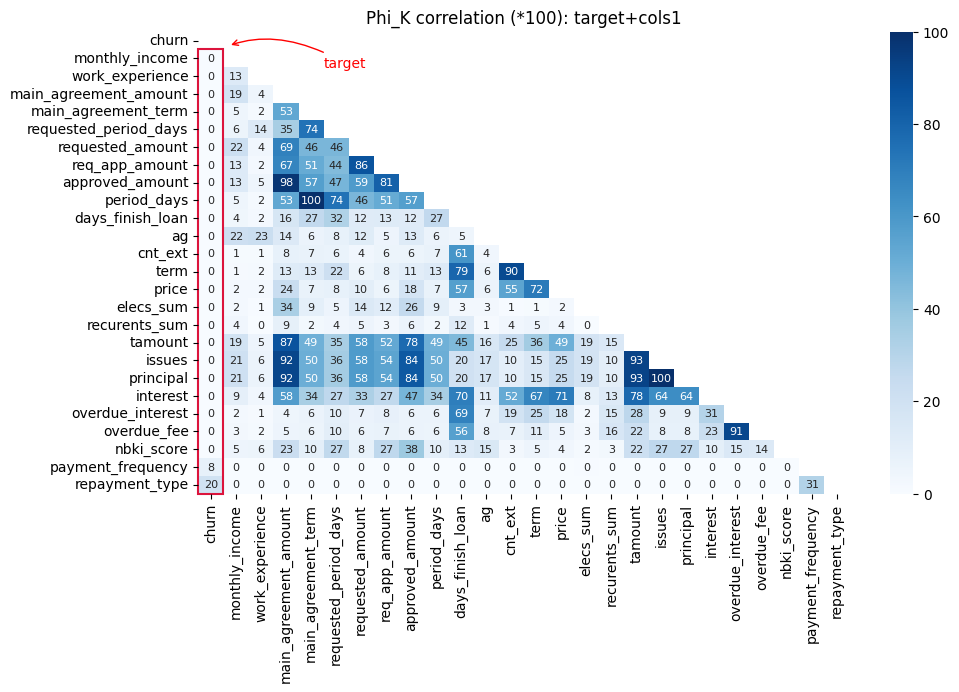

In [224]:
matrix_corr(phik_df1, title = ': target+cols1')

In [225]:
%%time
# Phi_K матрица из коэффициентов корреляции между признаками (целевой+вторая треть признаков)
phik_df2 = train[['churn']+cols2]\
          .phik_matrix(interval_cols=[i for i in cols2 if i in num_col])

CPU times: user 2min 34s, sys: 7.85 s, total: 2min 42s
Wall time: 3min 10s


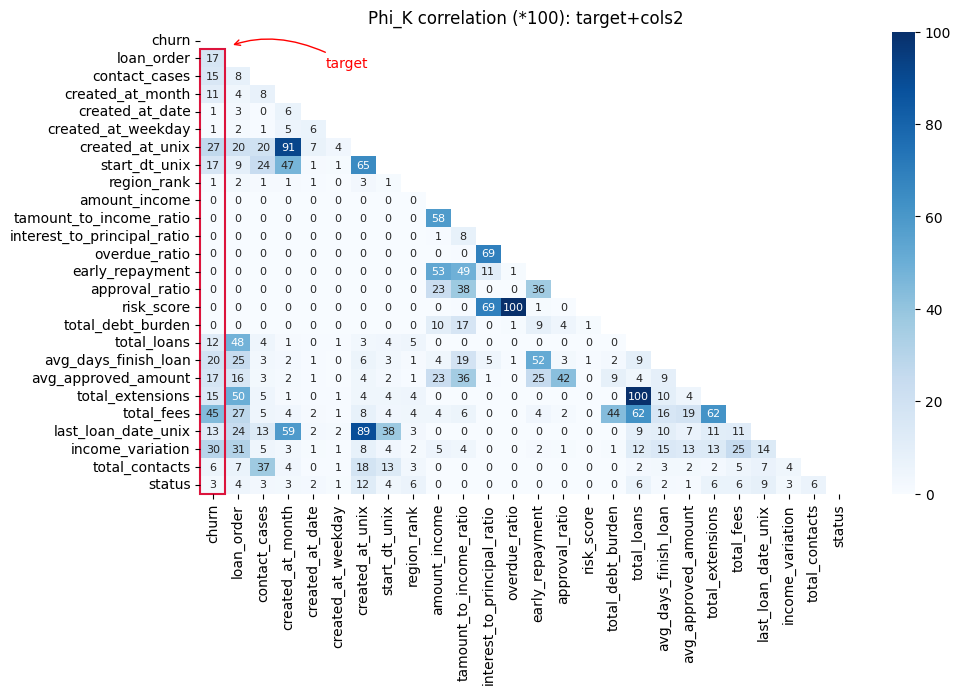

In [226]:
matrix_corr(phik_df2, title = ': target+cols2')

In [227]:
%%time
# Phi_K матрица из коэффициентов корреляции между признаками (целевой+последняя треть признаков)
# 'region_settlement' удаляем из-за слишком большого числа уник.знач.
phik_df3 = train[['churn']+cols3]\
          .drop('region_settlement',axis=1)\
          .phik_matrix(interval_cols=[i for i in cols3 if i in num_col], njobs=1)

CPU times: user 1min 12s, sys: 760 ms, total: 1min 13s
Wall time: 1min 13s


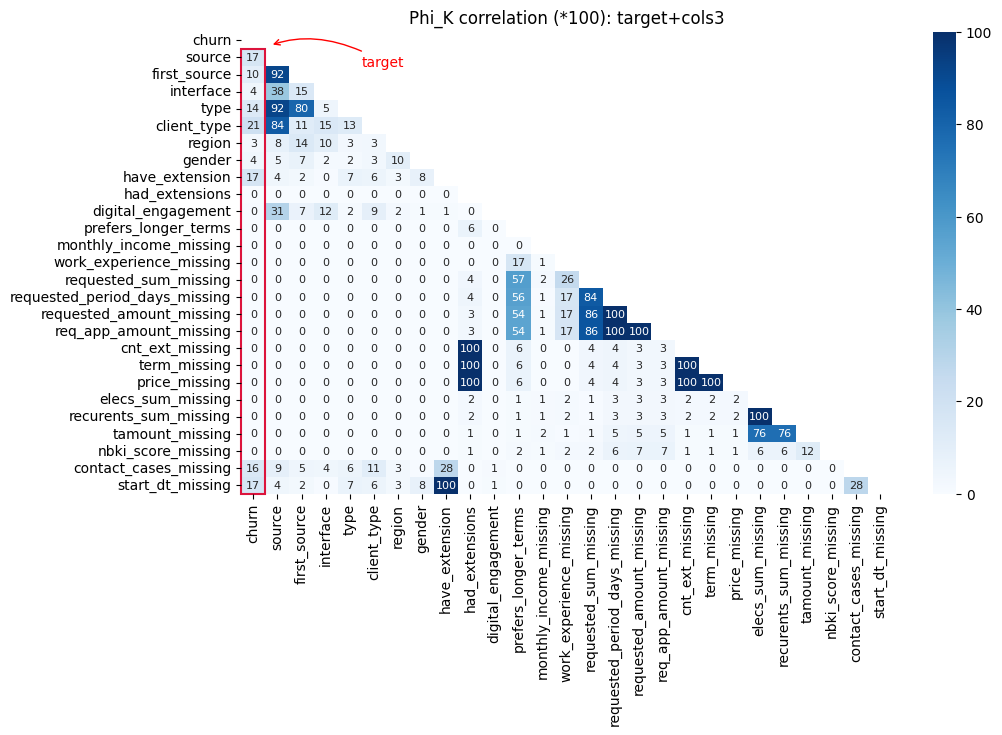

In [228]:
matrix_corr(phik_df3, title = ': target+cols3')

In [229]:
%%time
phik_df1_2 = train[['churn']+cols1+cols2]\
          .phik_matrix(interval_cols=[i for i in cols1+cols2 if i in num_col])

CPU times: user 9min 16s, sys: 19.8 s, total: 9min 36s
Wall time: 11min 37s


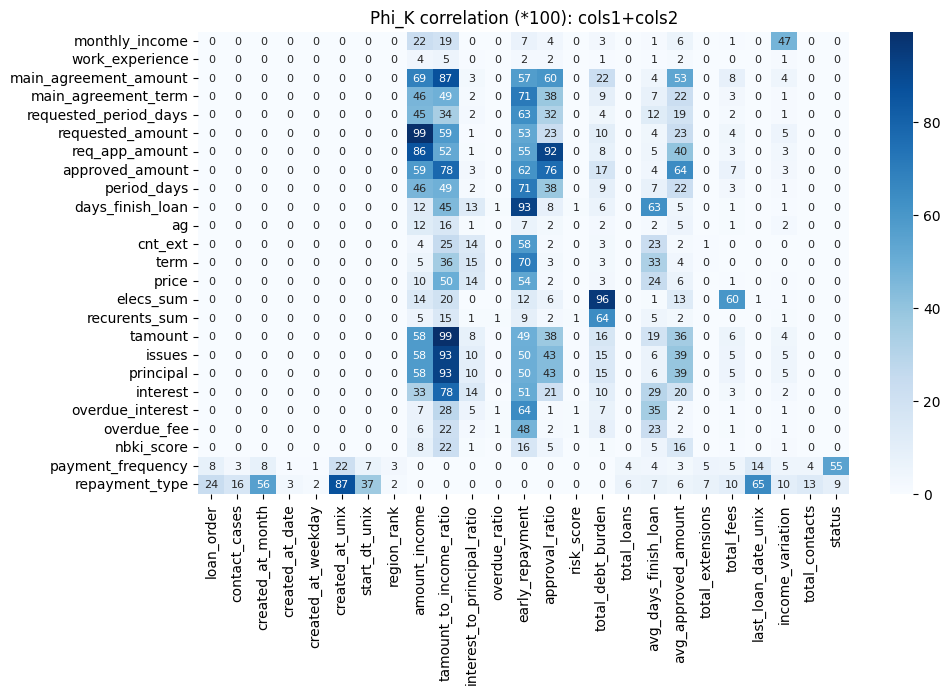

In [230]:
matrix_corr(phik_df1_2.loc[cols1,cols2], corner=False, title = ': cols1+cols2')

In [231]:
%%time
phik_df1_3 = train[['churn']+cols1+cols3]\
          .drop('region_settlement',axis=1)\
          .phik_matrix(interval_cols=[i for i in cols1+cols3 if i in num_col], njobs=1)

CPU times: user 10min 25s, sys: 37.9 s, total: 11min 3s
Wall time: 11min 3s


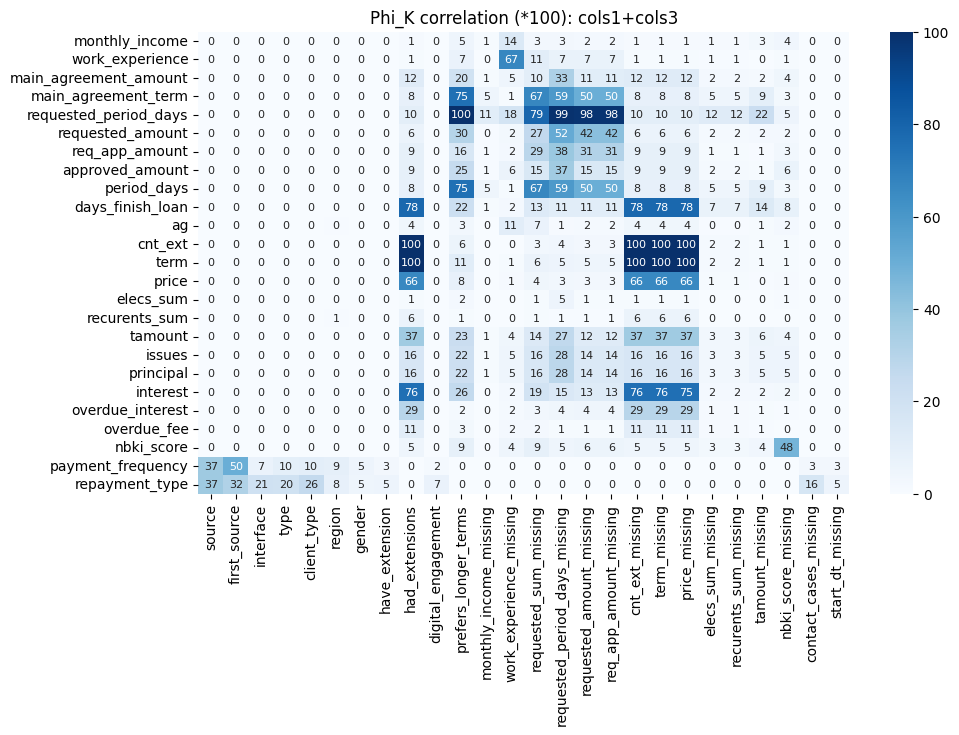

In [232]:
matrix_corr(phik_df1_3.loc[cols1, 
                           [_ for _ in cols3 if _!='region_settlement']], 
            corner=False, title = ': cols1+cols3')

In [233]:
%%time
phik_df2_3 = train[['churn']+cols2+cols3]\
          .drop('region_settlement',axis=1)\
          .phik_matrix(interval_cols=[i for i in cols2+cols3 if i in num_col], njobs=1)

CPU times: user 10min 10s, sys: 27.4 s, total: 10min 37s
Wall time: 10min 38s


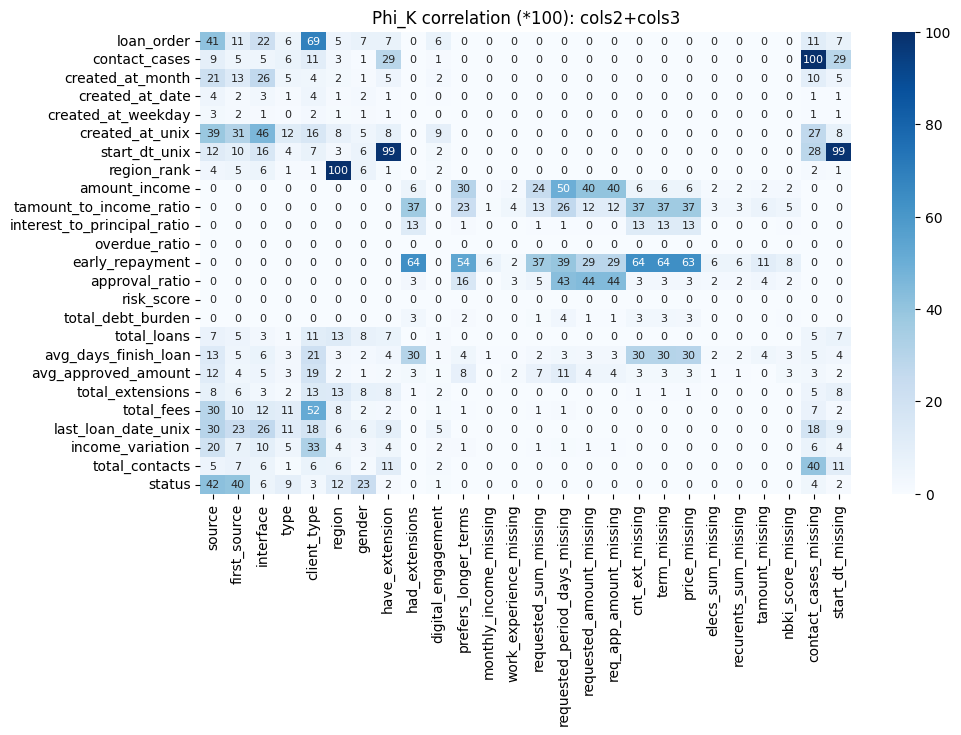

In [234]:
matrix_corr(phik_df2_3.loc[cols2,
                           [_ for _ in cols3 if _!='region_settlement']], 
            corner=False, title = ': cols2+cols3')

<a id= 'corr'></a>Признаки, которые больше всего коррелируют с целевым.\
Для ML отберём с коэффициентом >= 0.01 за вычетом мультиколлинеарных.\
Также не забываем, что надо включить region_settlement, который убирали из Phi_K.

In [235]:
cols_Phi_K = pd.concat([
    phik_df1['churn'][phik_df1['churn']>=0.01],
    phik_df2['churn'][phik_df2['churn']>=0.01],
    phik_df3['churn'][phik_df3['churn']>=0.01]]).drop('churn').sort_values(ascending=False)

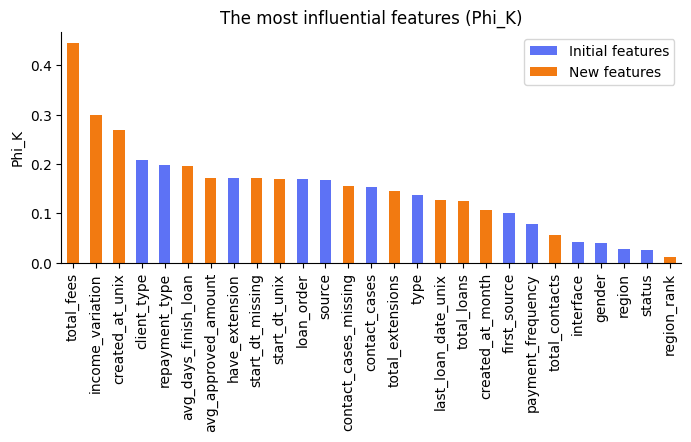

In [236]:
ax = cols_Phi_K.plot(kind='bar', figsize=(8,3), ylabel='Phi_K',
                     color=['#5d72f5' if i in cols_initial else '#f27a11' for i in cols_Phi_K.index ],
                     title='The most influential features (Phi_K)')
ax.legend(handles=[Patch(facecolor='#5d72f5', label='Initial features'),
                   Patch(facecolor='#f27a11', label='New features')])
sns.despine()

In [237]:
cols_Phi_K = [
    'payment_frequency',
    'repayment_type',
    'loan_order',
    # 'contact_cases',     # мульт-ть с 'contact_cases_missing'
    # 'created_at_month',  # мульт-ть с 'created_at_unix'
    'created_at_unix',
    # 'start_dt_unix'      # мульт-ть с 'have_extension', 'start_dt_missing'
    # 'region_rank'        # мульт-ть с 'region'
    # 'total_loans',       # мульт-ть с 'total_extensions'
    'avg_days_finish_loan',
    'avg_approved_amount',
    'total_extensions',
    'total_fees',
    'last_loan_date_unix',
    'income_variation',
    'total_contacts',
    'status',
    'source',
    # 'first_source',      # мульт-ть с 'source'
    'interface',
    # 'type',              # мульт-ть с 'source'
    'client_type',
    'region',
    'gender',
    # 'have_extension',    # мульт-ть с 'start_dt_missing'
    'contact_cases_missing',
    'start_dt_missing',
    'region_settlement'   # в Phi_K не было; но признак может быть влиятельный
    ]

num_col_Phi_K = list(set(cols_Phi_K)&set(num_col))
cat_col_Phi_K = list(set(cols_Phi_K)&set(cat_col))
cols_Phi_K    = num_col_Phi_K+cat_col_Phi_K
len(cols_Phi_K)

20

<a id= 'eda'></a>
### Conclusion

* Исходные данные массивны (1.4 ГБ, 0.4 ГБ).
* Большинство количественных данных получены закодироваными. Скорее всего, стандартизованы. Но после сделанных корректировок (выбросы, пропуски) необходимо будет опять стандартизовать.
* Есть признаки со значительной долей пропусков. Доли равны в train и в test. Пропуски заполнены логичными значениями - либо 0, либо среднее.
* Выбросы обрезаны до разумного уровня.
* В test отсутствуют признаки: churn (таргет) и closed_at.
* Полных дубликатов нет. Также нет полных дубликатов без учёта идентифицирующего признака loan_id; и нет дубликатов среди loan_id.
* Сделано множество новых признаков - финансовые, поведенческие, индикаторы пропусков, кредитный рейтинг региона. Некоторые показали хорошую корреляцию с целевым.
* Топ-5 наиболее влиятельных признаков по версии Phi_K: total_fees, income_variation, created_at_unix, client_type, repayment_type.

## ML

### Splitting (training + validation)

In [238]:
%%time
X_, X_v_, y, y_v = train_test_split(train.drop('churn', axis=1), 
                                    train.churn, 
                                    test_size   =0.25, 
                                    stratify    =train.churn, 
                                    random_state=random_state)

CPU times: user 5.68 s, sys: 1 s, total: 6.68 s
Wall time: 6.68 s


In [239]:
print(X_.  shape, y.  shape)
print(X_v_.shape, y_v.shape)

(3027155, 85) (3027155,)
(1009052, 85) (1009052,)


In [240]:
del train

### Logistic Regression

Воспользуемся только наиболее влиятельными признаками по версии Phi_K.\
Количественные стандартизируем, категориальные кодируем по OHE.
Так как есть признак с большим числом уникальных значений (region_settlement) ограничиваем максимальное кол-во категорий.

In [241]:
encoder_lr = scaling_coding(cols_scale=num_col_Phi_K, cols_ohe=cat_col_Phi_K)
encoder_lr.fit(X_[cols_Phi_K], max_categories=300)

In [242]:
%%time
X   = encoder_lr.transform(X_  [cols_Phi_K])
X_v = encoder_lr.transform(X_v_[cols_Phi_K])

CPU times: user 16.6 s, sys: 22.9 s, total: 39.4 s
Wall time: 39.4 s


In [243]:
# Преобразуем данные в cuDF (GPU-аналог pandas)
X_cudf = cudf.DataFrame(X)
y_cudf = cudf.Series(y)

X_v_cudf = cudf.DataFrame(X_v)
y_v_cudf = cudf.Series(y_v)

In [244]:
model_lr = LogisticRegression(max_iter=10000)
model_lr.fit(X_cudf, y_cudf)

[2025-03-11 11:19:27.177] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


LogisticRegression()

In [245]:
f1_score(y_v_cudf.to_numpy(), model_lr.predict(X_v_cudf).to_numpy()).round(5)

0.69933

In [246]:
probability = model_lr.predict_proba(X_v_cudf).to_numpy()[:,1]
probability

array([5.20897338e-05, 6.33376464e-02, 1.19324215e-01, ...,
       6.57291174e-01, 7.61703551e-01, 3.07302833e-01])

In [247]:
for threshold in np.arange(0.35,0.55,0.01):
    prediction = (probability>threshold).astype(int)
    print (f'{threshold:.2f}   {f1_score(y_v,prediction):.5f}')

0.35   0.70148
0.36   0.70568
0.37   0.70958
0.38   0.71305
0.39   0.71588
0.40   0.71824
0.41   0.72027
0.42   0.72150
0.43   0.72190
0.44   0.72163
0.45   0.72022
0.46   0.71811
0.47   0.71472
0.48   0.71105
0.49   0.70576
0.50   0.69933
0.51   0.69191
0.52   0.68352
0.53   0.67389
0.54   0.66306
0.55   0.65145


f1 = 0.72190 при threshold = 0.43

In [248]:
del X_cudf, y_cudf, X_v_cudf, y_v_cudf

### CatBoost

In [249]:
encoder_cb = scaling_coding(cols_scale=num_col, cols_untransformed = cat_col)
encoder_cb.fit(X_[cols])

In [250]:
%%time
X   = encoder_cb.transform(X_  [cols])
X_v = encoder_cb.transform(X_v_[cols])

CPU times: user 9.79 s, sys: 8.79 s, total: 18.6 s
Wall time: 18.5 s


In [251]:
def cb_func(X_train, Y_train, X_valid, Y_valid, learning_rate=0.1, depth=None, l2=None,
            min_data_in_leaf=None, cat_col=cat_col):
    global model_cb
    model_cb = CatBoostClassifier(loss_function="Logloss",
                                  iterations=5000,
                                  learning_rate=learning_rate,
                                  depth=depth,
                                  early_stopping_rounds=10,
                                  class_weights=[0.29, 0.71],
                                  cat_features=cat_col,
                                  task_type='GPU' if torch.cuda.is_available() else 'CPU',
                                  l2_leaf_reg=l2,
                                  min_data_in_leaf=min_data_in_leaf
                                 )

    model_cb.fit(X_train, Y_train, verbose=100, eval_set=(X_valid, Y_valid))

    return f1_score(Y_valid, model_cb.predict(X_valid))

In [252]:
cb_func(X, y, X_v, y_v, learning_rate=0.08, depth=8, 
        cat_col=list(range(len(num_col), len(cols))))

0:	learn: 0.6353787	test: 0.6353980	best: 0.6353980 (0)	total: 536ms	remaining: 44m 41s
100:	learn: 0.2215579	test: 0.2218381	best: 0.2218381 (100)	total: 37.7s	remaining: 30m 29s
200:	learn: 0.1994149	test: 0.1998307	best: 0.1998307 (200)	total: 1m 15s	remaining: 30m 6s
300:	learn: 0.1901916	test: 0.1908268	best: 0.1908268 (300)	total: 1m 54s	remaining: 29m 39s
400:	learn: 0.1849660	test: 0.1858570	best: 0.1858570 (400)	total: 2m 33s	remaining: 29m 17s
500:	learn: 0.1816081	test: 0.1828228	best: 0.1828228 (500)	total: 3m 11s	remaining: 28m 42s
600:	learn: 0.1795335	test: 0.1811758	best: 0.1811758 (600)	total: 3m 52s	remaining: 28m 24s
700:	learn: 0.1777820	test: 0.1799221	best: 0.1799221 (700)	total: 4m 33s	remaining: 27m 56s
800:	learn: 0.1763882	test: 0.1789773	best: 0.1789773 (800)	total: 5m 13s	remaining: 27m 24s
900:	learn: 0.1750018	test: 0.1780242	best: 0.1780242 (900)	total: 5m 54s	remaining: 26m 53s
1000:	learn: 0.1740391	test: 0.1775667	best: 0.1775667 (1000)	total: 6m 36s	r

0.9016253859253208

In [253]:
proba = model_cb.predict_proba(X_v)[:,1]
for threshold in np.arange(0.5,0.7,0.01):
    prediction = (proba>threshold).astype(int)
    print (f'{threshold:.2f}   {f1_score(y_v,prediction):.5f}')

0.50   0.90163
0.51   0.90276
0.52   0.90378
0.53   0.90459
0.54   0.90535
0.55   0.90589
0.56   0.90652
0.57   0.90707
0.58   0.90755
0.59   0.90791
0.60   0.90828
0.61   0.90861
0.62   0.90885
0.63   0.90898
0.64   0.90905
0.65   0.90913
0.66   0.90917
0.67   0.90923
0.68   0.90907
0.69   0.90897


f1 = 0.90923 при threshold = 0.67

#### Feature importance

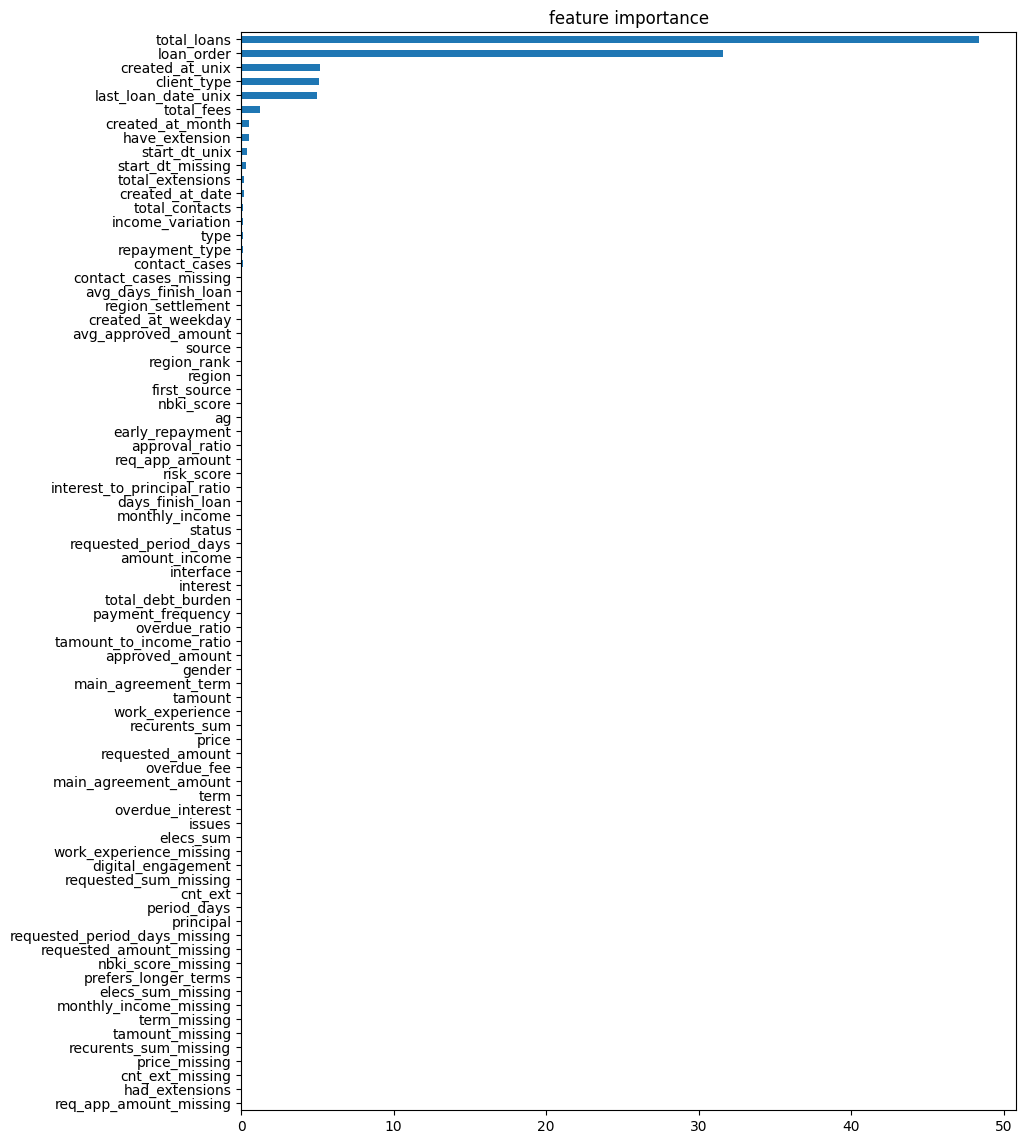

In [254]:
cv_dataset_test = Pool(data  = X_v,
                       label = y_v,
                       cat_features = list(range(len(num_col), len(cols))))

importances = model_cb.get_feature_importance(data=cv_dataset_test,
                                              type='FeatureImportance',
                                              prettified=False)

importances_s = pd.Series(importances,cols).sort_values()
importances_s.plot(kind='barh', figsize=(10,14), title='feature importance')
plt.show()

#### Best features

Лучшие признаки на основе feature importance & Phi_K за вычетом мультиколлинеарных.

In [255]:
cols_best_ = list(set(importances_s.tail(17).index)|set(cols_Phi_K))
print (*cols_best_)

avg_approved_amount contact_cases_missing client_type region_settlement start_dt_missing have_extension created_at_unix contact_cases region loan_order type start_dt_unix interface total_contacts repayment_type last_loan_date_unix income_variation created_at_month gender avg_days_finish_loan created_at_date source total_loans status total_fees total_extensions payment_frequency


In [256]:
cols_best = [
    'contact_cases',
    'gender',
    'avg_days_finish_loan',
    'income_variation',
    'total_contacts',
    'total_fees',
    'client_type',
    'region',
    #'total_extensions',       # мультиколлинеарен с 'total_loans'
    'last_loan_date_unix',
    'repayment_type',
    'start_dt_missing',
    #'created_at_month',       # м. с 'created_at_unix'
    'loan_order',
    'status',
    'created_at_date',
    #'start_dt_unix',          # м. с 'start_dt_missing'
    'interface',
    'payment_frequency',
    'created_at_unix',
    #'source',                 # м. с 'type'
    'avg_approved_amount',
    #'contact_cases_missing',  # м. с 'contact_cases'
    #'have_extension',         # м. с 'start_dt_missing'
    'region_settlement',
    'type',
    'total_loans'
    ]

num_col_best = list(set(cols_best)&set(num_col))
cat_col_best = list(set(cols_best)&set(cat_col))
cols_best    = num_col_best+cat_col_best
len(cols_best)

21

In [257]:
# индексы признаков
cols_best_i = [i[0] for i in enumerate(cols) if i[1] in cols_best]

In [258]:
cb_func(X[:,cols_best_i], y, X_v[:,cols_best_i], y_v, learning_rate=0.08, depth=8, 
        cat_col=list(range(len(num_col_best), len(cols_best))))

0:	learn: 0.6160134	test: 0.6161157	best: 0.6161157 (0)	total: 342ms	remaining: 28m 31s
100:	learn: 0.2212752	test: 0.2215833	best: 0.2215833 (100)	total: 31.7s	remaining: 25m 36s
200:	learn: 0.1994093	test: 0.1998191	best: 0.1998191 (200)	total: 1m 3s	remaining: 25m 5s
300:	learn: 0.1900516	test: 0.1906287	best: 0.1906287 (300)	total: 1m 34s	remaining: 24m 32s
400:	learn: 0.1846544	test: 0.1853844	best: 0.1853844 (400)	total: 2m 6s	remaining: 24m 6s
500:	learn: 0.1813436	test: 0.1822696	best: 0.1822696 (500)	total: 2m 38s	remaining: 23m 47s
600:	learn: 0.1790754	test: 0.1803359	best: 0.1803359 (600)	total: 3m 14s	remaining: 23m 41s
700:	learn: 0.1772693	test: 0.1788479	best: 0.1788479 (700)	total: 3m 48s	remaining: 23m 22s
800:	learn: 0.1756248	test: 0.1775515	best: 0.1775515 (800)	total: 4m 25s	remaining: 23m 9s
900:	learn: 0.1744918	test: 0.1767933	best: 0.1767933 (900)	total: 5m 1s	remaining: 22m 53s
1000:	learn: 0.1734739	test: 0.1761952	best: 0.1761952 (1000)	total: 5m 40s	remain

0.9019152179805698

In [259]:
proba = model_cb.predict_proba(X_v[:,cols_best_i])[:,1]
for threshold in np.arange(0.6,0.7,0.01):
    prediction = (proba>threshold).astype(int)
    print (f'{threshold:.2f}   {f1_score(y_v,prediction):.5f}')

0.60   0.90878
0.61   0.90920
0.62   0.90951
0.63   0.90966
0.64   0.90983
0.65   0.90992
0.66   0.90995
0.67   0.90992
0.68   0.90994
0.69   0.90980


#### Feature importance

In [260]:
cv_dataset_test = Pool(data  = X_v[:,cols_best_i],
                       label = y_v,
                       cat_features = list(range(len(num_col_best), len(cols_best))))

importances = model_cb.get_feature_importance(data=cv_dataset_test,
                                              type='FeatureImportance',
                                              prettified=False)

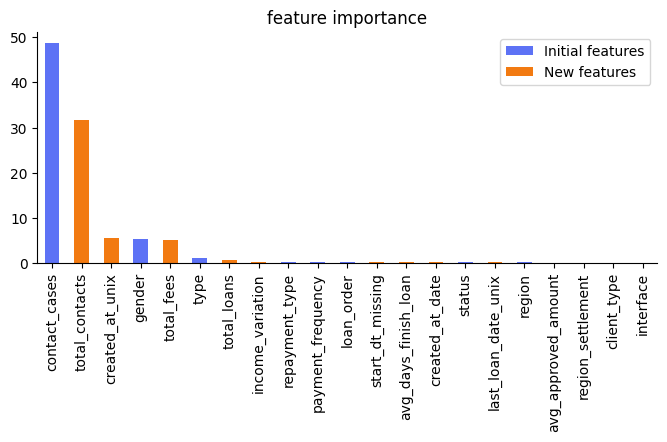

In [261]:
importances_s = pd.Series(importances,cols_best).sort_values(ascending=False)
ax = importances_s.plot(kind='bar', figsize=(8,3),
                     color=['#5d72f5' if i in cols_initial else '#f27a11' 
                            for i in importances_s.index],
                     title='feature importance')
ax.legend(handles=[Patch(facecolor='#5d72f5', label='Initial features'),
                   Patch(facecolor='#f27a11', label='New features')])
sns.despine()

<a id= 'cb'></a>
#### Conclusion

f1 = 0.90995

Стандартизация количественных признаков. Категориальные не кодировались.\
Пробовались различные гиперпараметры и число используемых признаков.

|hyperparameters|experimental range|chosen value|
|---|---|---|
|depth|[3,9]|8|
|learning_rate|[0.01, 0.10]|0.08|
|l2_leaf_reg|(8, None)|None|
|min_data_in_leaf|(2000, None)|None|
|class_weights|([0.29, 0.71], None)|[0.29, 0.71]|
|one_hot_max_size|(20, 200, 256, None)|None|
|threshold|[0.5,0.7]|0.66|
|number of features|(77(all), 21(best))|21(best)|

### Neural network

Используем лучшие признаки (21шт.).

In [262]:
# кол-во уникальных значений среди категориальных признаков
X_[cat_col_best].nunique()

region_settlement    50981
client_type              2
start_dt_missing         2
gender                   2
status                  10
region                  89
interface                3
type                     4
dtype: int64

`region_settlement` & `region` закодируем через target encoder, остальные категориальные с помощью OHE

In [263]:
encoder_nn = scaling_coding(cols_scale=num_col_best, 
                         cols_ohe=[i for i in cat_col_best if i not in ('region_settlement', 
                                                                        'region')], 
                         cols_te=['region_settlement', 'region'])

encoder_nn.fit(X_[cols_best],y)

In [264]:
%%time
X   = encoder_nn.transform(X_  [cols_best])
X_v = encoder_nn.transform(X_v_[cols_best])

CPU times: user 12.5 s, sys: 2.73 s, total: 15.2 s
Wall time: 15.2 s


In [265]:
print(X.  shape, y.  shape)
print(X_v.shape, y_v.shape)

(3027155, 38) (3027155,)
(1009052, 38) (1009052,)


In [266]:
def neural_net(print_info = True):
    '''вычисляет минимальный BCE в двойном цикле по эпохам и батчам; сообщает на какой эпохе достигнут лучший BCE_test;
       выводит динамику изменения BCE на графике'''

    global prediction_test_best, df_BCE, model_best

    torch.manual_seed(random_state)

    # если GPU доступен, создаём тензоры для работы на GPU; иначе - обычные тензоры для CPU
    X_train_ = torch.FloatTensor(X).to(device)
    X_test_  = torch.FloatTensor(X_v).to(device)
    y_train_ = torch.FloatTensor(y.values).to(device)
    y_test_  = torch.FloatTensor(y_v.values).to(device)

    count_higher_BCE = 0
    df_BCE = []
    n_epoch = []
    sign_stop = False
    for epoch in range(num_epochs):
        if sign_stop:
            break

        # случайная перестановка объектов
        order = np.random.permutation(len(X_train_))
        for batch_idx in range(num_batches):
            start_index = batch_idx*batch_size

            # получение индексов текущего батча
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train_[batch_indexes]
            y_batch = y_train_[batch_indexes]

            optimizer.zero_grad()
            prediction = model.forward(X_train_)
            loss_value = loss(prediction.flatten(), y_train_)
            loss_value.backward()
            optimizer.step()

            # фиксирование BCE в конце какого-то по счёту батча и последнего
            if batch_idx%10 == 0 or batch_idx+1 == num_batches:
                print(' '*50, end='\r') # закрашивает последнее значение счётчика
                print (f"Вычисляется батч {batch_idx+1} из {num_batches} (эпоха {epoch+1} из {num_epochs})",
                       end='\r') # счётчик батчей
                
                BCE_train = loss_value.item()

                # на тестовой выборке; блок кода для расчёта метрик в режиме инференса
                with torch.no_grad():
                    model.eval()
                    prediction_test = model.forward(X_test_)
                    BCE_test = loss(prediction_test.flatten(), y_test_).item()
                    model.train()

                # накопление данных для формирования df
                df_BCE.append([batch_idx+1, BCE_train, BCE_test])
                n_epoch.append(round(epoch+(batch_idx+1)/num_batches_per_epoch, 3))

                # фиксирование начальных BCE и предсказания на случай, если в самом начале попали в идеальное предсказание
                if epoch==0 and batch_idx == 0:
                    BCE_test_best = BCE_test
                    prediction_test_best = prediction_test
                    model_best = model
                    BCE_test_last = BCE_test  # техническое присвоение для начального батча чтобы сработал if ниже

                # прерывание цикла, если в течении нескольких замеров подряд BCE_test увеличивается
                if BCE_test >= BCE_test_last and count_higher_BCE < 5:   
                    count_higher_BCE+=1
                    BCE_test_last = BCE_test
                elif BCE_test < BCE_test_last:
                    BCE_test_last = BCE_test
                    count_higher_BCE = 0
                    if BCE_test<BCE_test_best:
                        BCE_test_best = BCE_test
                        prediction_test_best = prediction_test
                        model_best = model
                else:
                    sign_stop=True
                    break
     
    if print_info:
        # печать графика
        df_BCE=pd.DataFrame(df_BCE, n_epoch, ['batch', 'train', 'test'])
        BCE_test_best_last  = round(df_BCE.tail(5).test.min(), 4)
        epoch_best_last     = df_BCE.tail(5).test.idxmin().astype(int)
        batch_best_last     = df_BCE.batch[df_BCE.tail(5).test.idxmin()]
        BCE_train_last_test = round(df_BCE.train[df_BCE.tail(5).test.idxmin()], 4)

        BCE_test_best_      = round(df_BCE.test.min(), 4)
        epoch_best          = df_BCE.test.idxmin().astype(int)
        batch_best          = df_BCE.batch[df_BCE.test.idxmin()]
        BCE_train_test      = round(df_BCE.train[df_BCE.test.idxmin()], 4)
               
        f, ax = plt.subplots(1,2, gridspec_kw={"width_ratios": (0.8, 0.2)}, figsize=(10,3))
        df_BCE.plot(y=['train', 'test'], grid=True, title='BCE на обучающей и тестовой выборках', 
                    xlabel='эпоха', ax=ax[0])
        plt.text(0, 0.75, f"Наименьшее (на последних батчах) \nBCE_test  = {BCE_test_best_last}\
            {epoch_best_last} эп.   {batch_best_last} б.\nBCE_train = {BCE_train_last_test}")
        plt.text(0, 0.5,  f"Наименьшее (на всех батчах) \nBCE_test  = {BCE_test_best_}\
            {epoch_best} эп.   {batch_best} б.\nBCE_train = {BCE_train_test}")
        plt.text(0, 0, f"num_epochs_max = {num_epochs}\nbatch_size = {batch_size}\
            \nlr = {optimizer.state_dict()['param_groups'][0]['lr']}", color='grey')
        plt.axis('off'); plt.show()

In [267]:
class NeuralNet(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(NeuralNet,self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.dp1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)


    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)


        return x

In [268]:
pos_weight = torch.tensor([0.71 / 0.29]).to(device)

model = NeuralNet(38,15,4,1).to(device)
loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

In [269]:
batch_size = 2000
num_batches_per_epoch = ceil(len(X)/batch_size)
num_batches_per_epoch

1514

In [270]:
num_epochs = 10
num_batches = num_batches_per_epoch

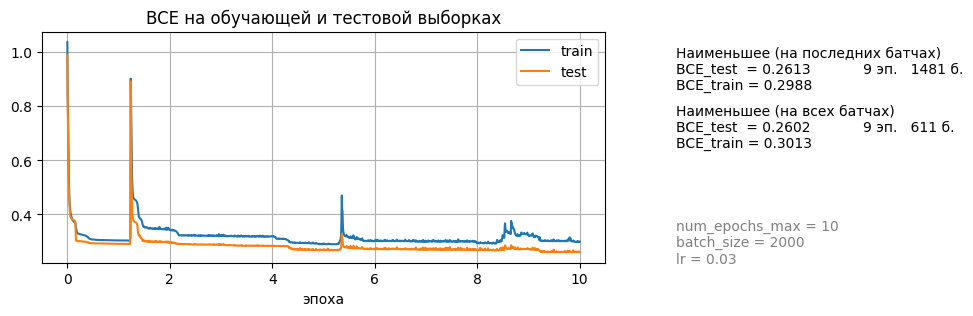

In [271]:
neural_net()

In [272]:
s = nn.Sigmoid()
f1_score(y_v, (s(prediction_test_best)>0.63).cpu())

0.9105109261601007

В ходе экспериментов пробовались:
- различные архитектуры нейронной сети (число слоёв, нейронов, batchnorm, dropout, ф-ии активации);
- learning rate [0.001, 0.3];
- threshhold = [0.5, 0.8];
- число эпох и батчей определялось с помощью early_stopping (в течение 5 замеров метрика не улучшается).

В итоге лучший результат f1=0.9105 получен при:
- только лучшие признаки (21шт.);
- стандартизация количественных признаков, OHE категориальных, кроме ['region_settlement', 'region'] (много уникальных значений) - с этими двумя Target Encoding;
- архитектура - (38,15, ReLu, Dropout, 4, Tanh, 1);
- learning rate = 0.03;
- threshhold = 0.63.

### Test prediction

Лучший стабильный результат показал CatBoost на отобранных признаках.\
Neural Network хоть и показала незначительно более высокое качество, но является крайне не стабильной.\
В производство берём CatBoost.

In [273]:
X = encoder_cb.transform(test[cols])
proba = model_cb.predict_proba(X[:,cols_best_i])[:,1]
prediction = (proba>0.66).astype(int)

In [274]:
test_prediction_v07 = test['loan_id'].to_frame().join(pd.DataFrame(prediction, test.index, ['churn']))
test_prediction_v07.head()

loan_id  churn
0  4057275      0
1   548313      0
2  1978430      0
3  2884196      1
4  3647374      0

In [275]:
#test_prediction_v07.to_csv('test_prediction_v07.csv', index=False)

f1_test = 0.90514
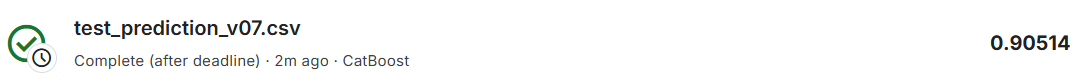

Необходимо проверять лучшую модель на тестовой выборке только 1 раз, что и сделано выше с алгоритмом CatBoost.\
Тем не менее, ради интереса, оценим результат, если бы в качестве итоговой модели была бы выброна Neural Network.

In [276]:
X = encoder_nn.transform(test[cols])
X = torch.FloatTensor(X).to(device)
prediction_nn = model_best.forward(X)

In [277]:
s = nn.Sigmoid()
prediction_nn = (s(prediction_nn)>0.63).cpu().numpy().flatten().astype(int)

In [278]:
test_prediction_v08 = test['loan_id'].to_frame().join(pd.DataFrame(prediction_nn, 
                                                                   test.index, ['churn']))
test_prediction_v08.head()

loan_id  churn
0  4057275      0
1   548313      0
2  1978430      0
3  2884196      1
4  3647374      0

In [279]:
#test_prediction_v08.to_csv('test_prediction_v08.csv', index=False)

f1_test = 0.88950
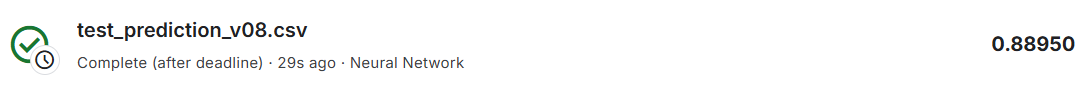

## Conclusion

Создана модель прогнозирующая отток с качеством f1 = 0.90514.\
Алгоритм на базе CatBoost. Подробнее в [п.4.3.4 Conclusion](#cb).

Также были проведены эксперименты с Logistic Regression (f1=0.72190) и Neural Network (f1=0.9105; нестабильный результат).

Значительный вклад в качество модели внесли новые созданные признаки (см. диаграмму в [п.3.3 Correlation](#corr)).

Вывод по EDA в [п.3.4](#eda).